## Import packages

In [2]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import itertools
import logging

import harmonica as hm
import numpy as np
import pandas as pd
import pooch
import verde as vd
import xarray as xr
from polartoolkit import maps
from polartoolkit import utils as polar_utils
from tqdm.autonotebook import tqdm

from invert4geom import (
    cross_validation,
    inversion,
    plotting,
    regional,
    utils,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get data

Here we will load a commonly used synthetic gravity and basement topography model. It includes topography of the Moho and the sediment-basement contact, and the forward modelled gravity effect of each, providing a synthetic observed gravity dataset.

In [3]:
# from https://wiki.seg.org/wiki/Bishop_Model

url = "https://drive.usercontent.google.com/download?id=0B_notXWcvuh8dGZWbHlGODRMWEE&export=download&authuser=0&confirm=t&uuid=5d6bd6a1-a14b-48b6-ac76-6eda9f1baf1d&at=APZUnTVqVzwqlXHZAiYK-RoxHsH6%3A1713697379614"
fname = "bishop_Geosoft_grids.tar.gz"
known_hash = None
path = pooch.retrieve(
    url=url,
    fname=fname,
    path=pooch.os_cache("bishop"),
    known_hash=known_hash,
    progressbar=True,
    processor=pooch.Untar(extract_dir=pooch.os_cache("bishop")),
)
geosoft_grids = [p for p in path if (p.endswith((".grd", ".GRD")))]
geosoft_grids

['/home/mdtanker/.cache/bishop/Geosoft_grids/bishop5x_mag_base_20000_i0.grd',
 '/home/mdtanker/.cache/bishop/Geosoft_grids/bishop5x_mag_base_moho_i30.grd',
 '/home/mdtanker/.cache/bishop/Geosoft_grids/bishop5x_mag_base_30000_i45.grd',
 '/home/mdtanker/.cache/bishop/Geosoft_grids/bishop5x_mag_base_20000_i30.grd',
 '/home/mdtanker/.cache/bishop/Geosoft_grids/bishop5x_mag_base_15000_i0.grd',
 '/home/mdtanker/.cache/bishop/Geosoft_grids/bishop5x_moho.GRD',
 '/home/mdtanker/.cache/bishop/Geosoft_grids/bishop5x_mag_base_15000_i60.grd',
 '/home/mdtanker/.cache/bishop/Geosoft_grids/bishop5x_susceptibility.grd',
 '/home/mdtanker/.cache/bishop/Geosoft_grids/bishop5x_mag_base_20000_i90.grd',
 '/home/mdtanker/.cache/bishop/Geosoft_grids/bishop5x_gravity.grd',
 '/home/mdtanker/.cache/bishop/Geosoft_grids/bishop5x_mag_base_15000_i30.grd',
 '/home/mdtanker/.cache/bishop/Geosoft_grids/bishop5x_basement.grd',
 '/home/mdtanker/.cache/bishop/Geosoft_grids/bishop5x_mag_base_20000_i60.grd',
 '/home/mdtanke

In [4]:
# get the necessary file paths
basement_path = [p for p in geosoft_grids if p.endswith("bishop5x_basement.grd")][0]  # noqa: RUF015
gravity_path = [p for p in geosoft_grids if p.endswith("bishop5x_gravity.grd")][0]  # noqa: RUF015
moho_path = [p for p in geosoft_grids if p.endswith("bishop5x_moho.GRD")][0]  # noqa: RUF015

In [5]:
# convert the .grd into xarray data arrays
basement = hm.load_oasis_montaj_grid(basement_path)
gravity = hm.load_oasis_montaj_grid(gravity_path)
moho = hm.load_oasis_montaj_grid(moho_path)

# merge into a dataset
data = xr.Dataset(
    {
        "basement": basement,
        "gravity": gravity,
        "moho": moho,
    }
)
data

<xarray.Dataset> Size: 92MB
Dimensions:   (easting: 1901, northing: 2011)
Coordinates:
  * easting   (easting) float64 15kB 2e+03 2.2e+03 ... 3.818e+05 3.82e+05
  * northing  (northing) float64 16kB 1.41e+05 1.412e+05 ... 5.428e+05 5.43e+05
Data variables:
    basement  (northing, easting) float64 31MB -6.068e+03 ... -8.099e+03
    gravity   (northing, easting) float64 31MB 99.3 99.29 99.28 ... 106.7 106.7
    moho      (northing, easting) float64 31MB -2.781e+04 ... -2.553e+04

In [6]:
# resample to low resolution for testing purposes
data = data.coarsen(easting=30, northing=30, boundary="trim").mean()
data

<xarray.Dataset> Size: 102kB
Dimensions:   (northing: 67, easting: 63)
Coordinates:
  * easting   (easting) float64 504B 4.9e+03 1.09e+04 ... 3.709e+05 3.769e+05
  * northing  (northing) float64 536B 1.439e+05 1.499e+05 ... 5.399e+05
Data variables:
    basement  (northing, easting) float64 34kB -6.15e+03 ... -8.111e+03
    gravity   (northing, easting) float64 34kB 99.16 99.03 99.24 ... 107.9 107.2
    moho      (northing, easting) float64 34kB -2.773e+04 ... -2.554e+04

# Define model domain parameters
To account for edge effects (decreasing gravity towards the edge of prism model), we will use a buffer region and a smaller inversion region so the prism model edge is further away from the inversion domain.

In [7]:
buffer_region = vd.get_region(
    (data.basement.easting.values, data.basement.northing.values)
)
inversion_region = vd.pad_region(buffer_region, -60e3)

grav_spacing = polar_utils.get_grid_info(data.gravity)[0]
topo_spacing = polar_utils.get_grid_info(data.basement)[0]
grav_spacing

6000.0

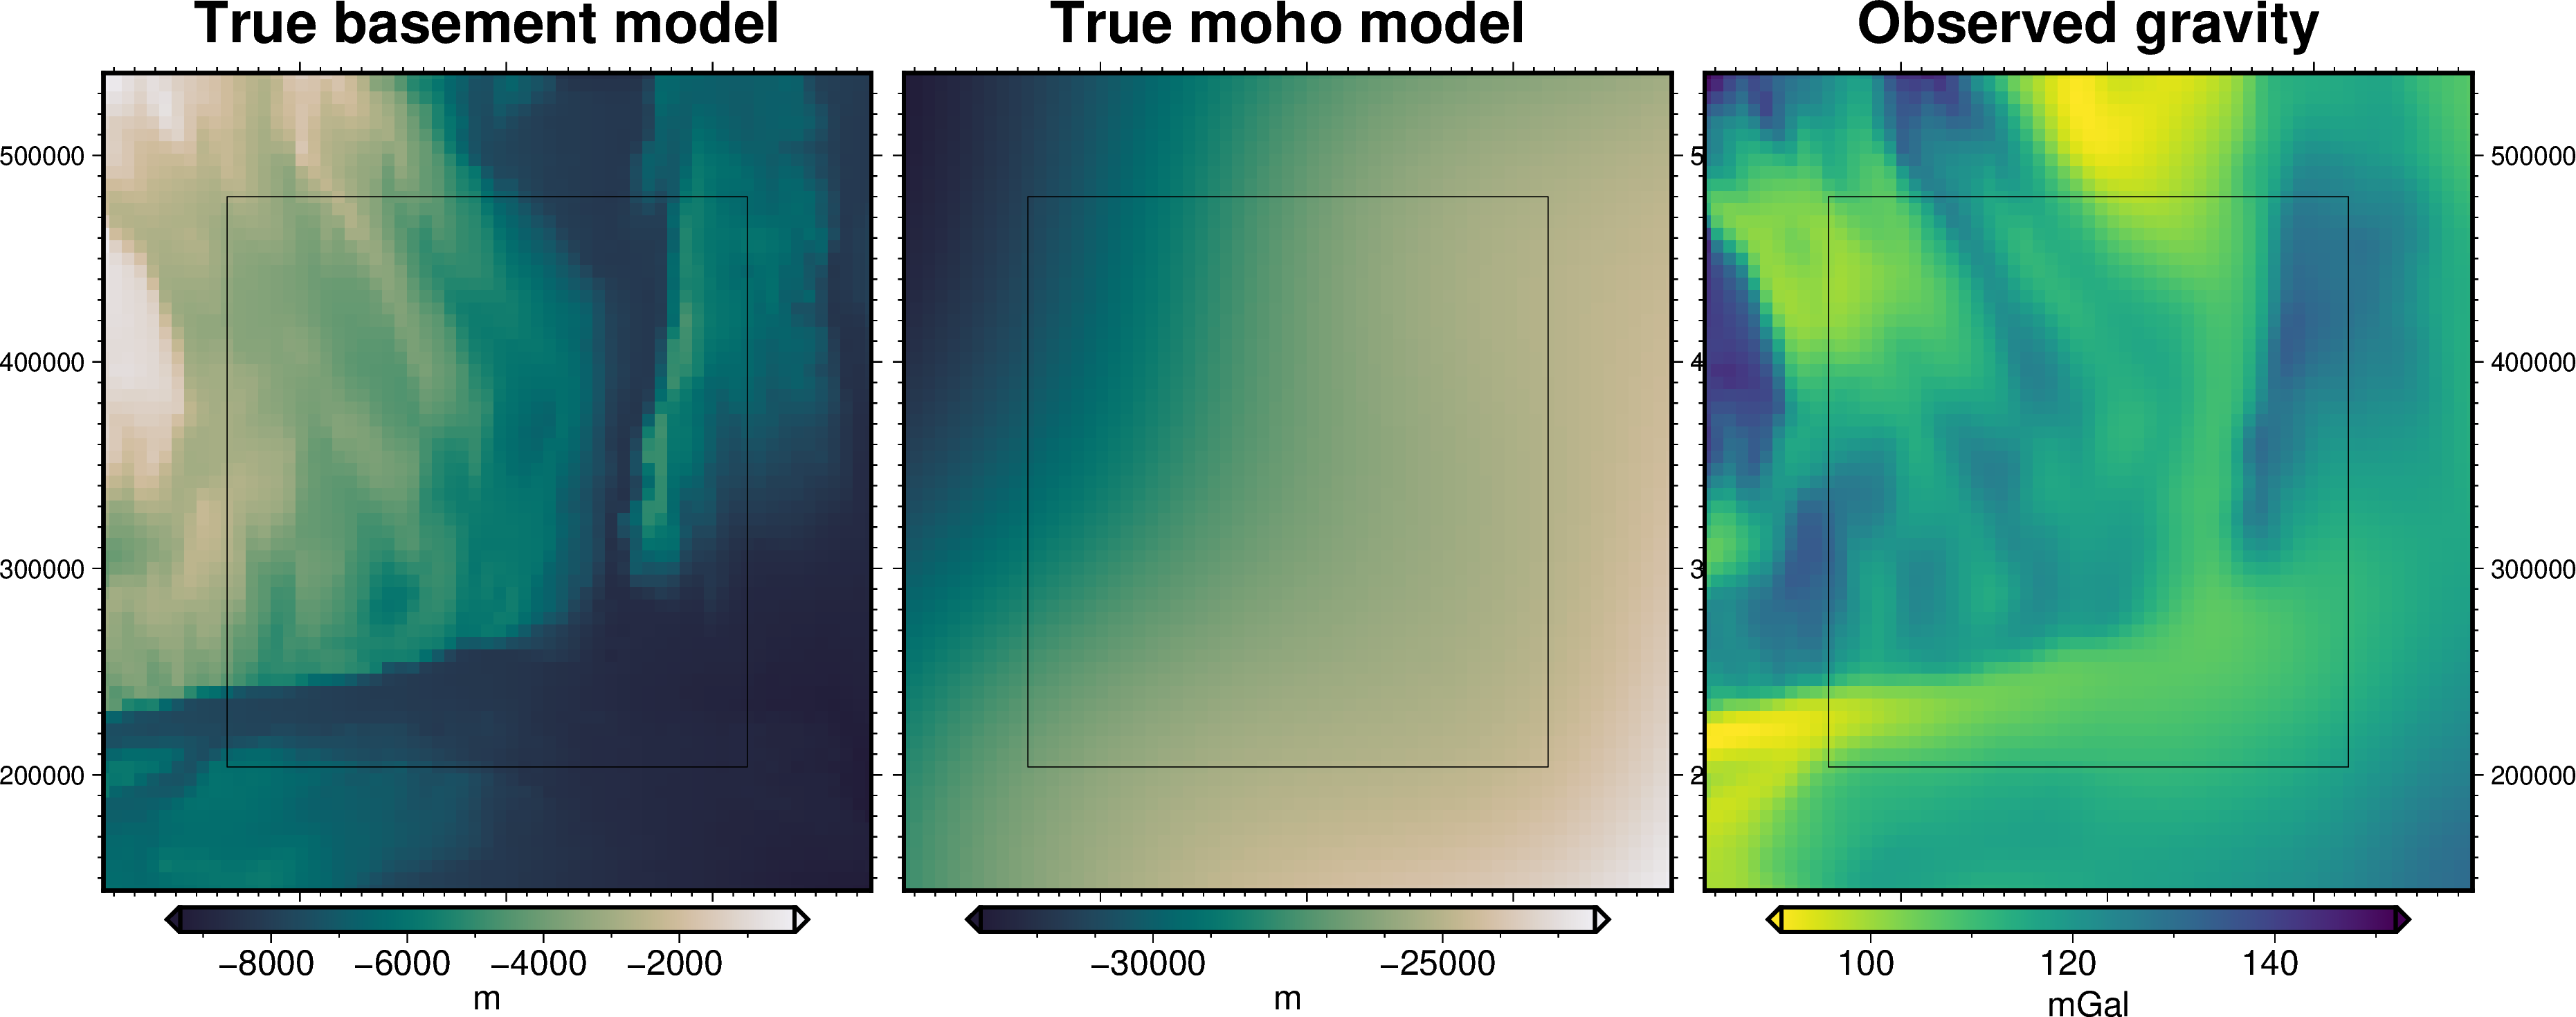

In [14]:
fig = maps.plot_grd(
    data.basement,
    fig_height=10,
    title="True basement model",
    reverse_cpt=True,
    cmap="rain",
    cbar_label="m",
    frame=["nSWe", "xaf10000", "yaf10000"],
    show_region=inversion_region,
)

fig = maps.plot_grd(
    data.moho,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="True moho model",
    reverse_cpt=True,
    cmap="rain",
    cbar_label="m",
    frame=["nSwE", "xaf10000", "yaf10000"],
    show_region=inversion_region,
)

fig = maps.plot_grd(
    data.gravity,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Observed gravity",
    reverse_cpt=True,
    cmap="viridis",
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
    show_region=inversion_region,
)

fig.show()

# Observed gravity data

In this scenario, we are treating the area as having no surface topography (surface elevation is flat and equal to the ellipsoid). In this case, there is no terrain mass effect, and therefore the gravity disturbance is equal to the topo-free disturbance.

In [28]:
grav_df = data.gravity.rename("topo_free_disturbance").to_dataframe().reset_index()
grav_df["upward"] = 10
grav_df

,northing,easting,topo_free_disturbance,upward
0,143900.0,4900.0,99.162018,10
1,143900.0,10900.0,99.028225,10
2,143900.0,16900.0,99.236420,10
3,143900.0,22900.0,99.936273,10
4,143900.0,28900.0,101.188770,10
...,...,...,...,...
4216,539900.0,352900.0,110.658439,10
4217,539900.0,358900.0,109.497489,10
4218,539900.0,364900.0,108.679903,10
4219,539900.0,370900.0,107.946382,10


## Calculate gravity effect of the Moho
This is already included in the "observed gravity" but we calculate it from the Moho topography in order to access the effectiveness of our regional seperation.

In [29]:
# pick a reference height for the moho
zref = data.moho.values.mean()

# pick a density contrast for the moho
density_contrast = 3300 - 2700

# prisms are created between zref and the height of the topography, which for this
# starting model is flat.
# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density = xr.where(data.moho >= zref, density_contrast, -density_contrast)

# create layer of prisms
moho_prisms = utils.grids_to_prisms(
    data.moho,
    zref,
    density=density,
)

# calculate forward gravity of starting prism layer
grav_df["moho_grav"] = moho_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

  0%|          | 0/4221 [00:00<?, ?it/s]

In [30]:
# resample to half spacing
grav_df = cross_validation.resample_with_test_points(
    grav_spacing, grav_df, inversion_region
)
grav_df

,northing,easting,test,topo_free_disturbance,upward,moho_grav
0,203900.0,64900.0,False,105.394936,10,0.723573
1,203900.0,67900.0,True,106.236773,10,1.639907
2,203900.0,70900.0,False,106.961624,10,2.556559
3,203900.0,73900.0,True,107.668294,10,3.470678
4,203900.0,76900.0,False,108.285965,10,4.380654
...,...,...,...,...,...,...
7900,479900.0,304900.0,False,125.541908,10,25.686832
7901,479900.0,307900.0,True,125.260601,10,26.058365
7902,479900.0,310900.0,False,125.007927,10,26.403393
7903,479900.0,313900.0,True,124.769899,10,26.721344


# Create "a-priori" basement measurements

In [31]:
# create 10 random point within the outcropping basement region
num_constraints = 10
coords = vd.scatter_points(
    region=inversion_region, size=num_constraints, random_state=7
)
constraint_points = pd.DataFrame(data={"easting": coords[0], "northing": coords[1]})

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points, data.basement, "upward", coord_names=("easting", "northing")
)

# Create starting basement model

In [32]:
# grid the sampled values using verde
grd = vd.Spline()
coords = (constraint_points.easting, constraint_points.northing)
grd.fit(coords, constraint_points.upward)
starting_topography = grd.grid(
    region=buffer_region,
    spacing=topo_spacing,
).scalars

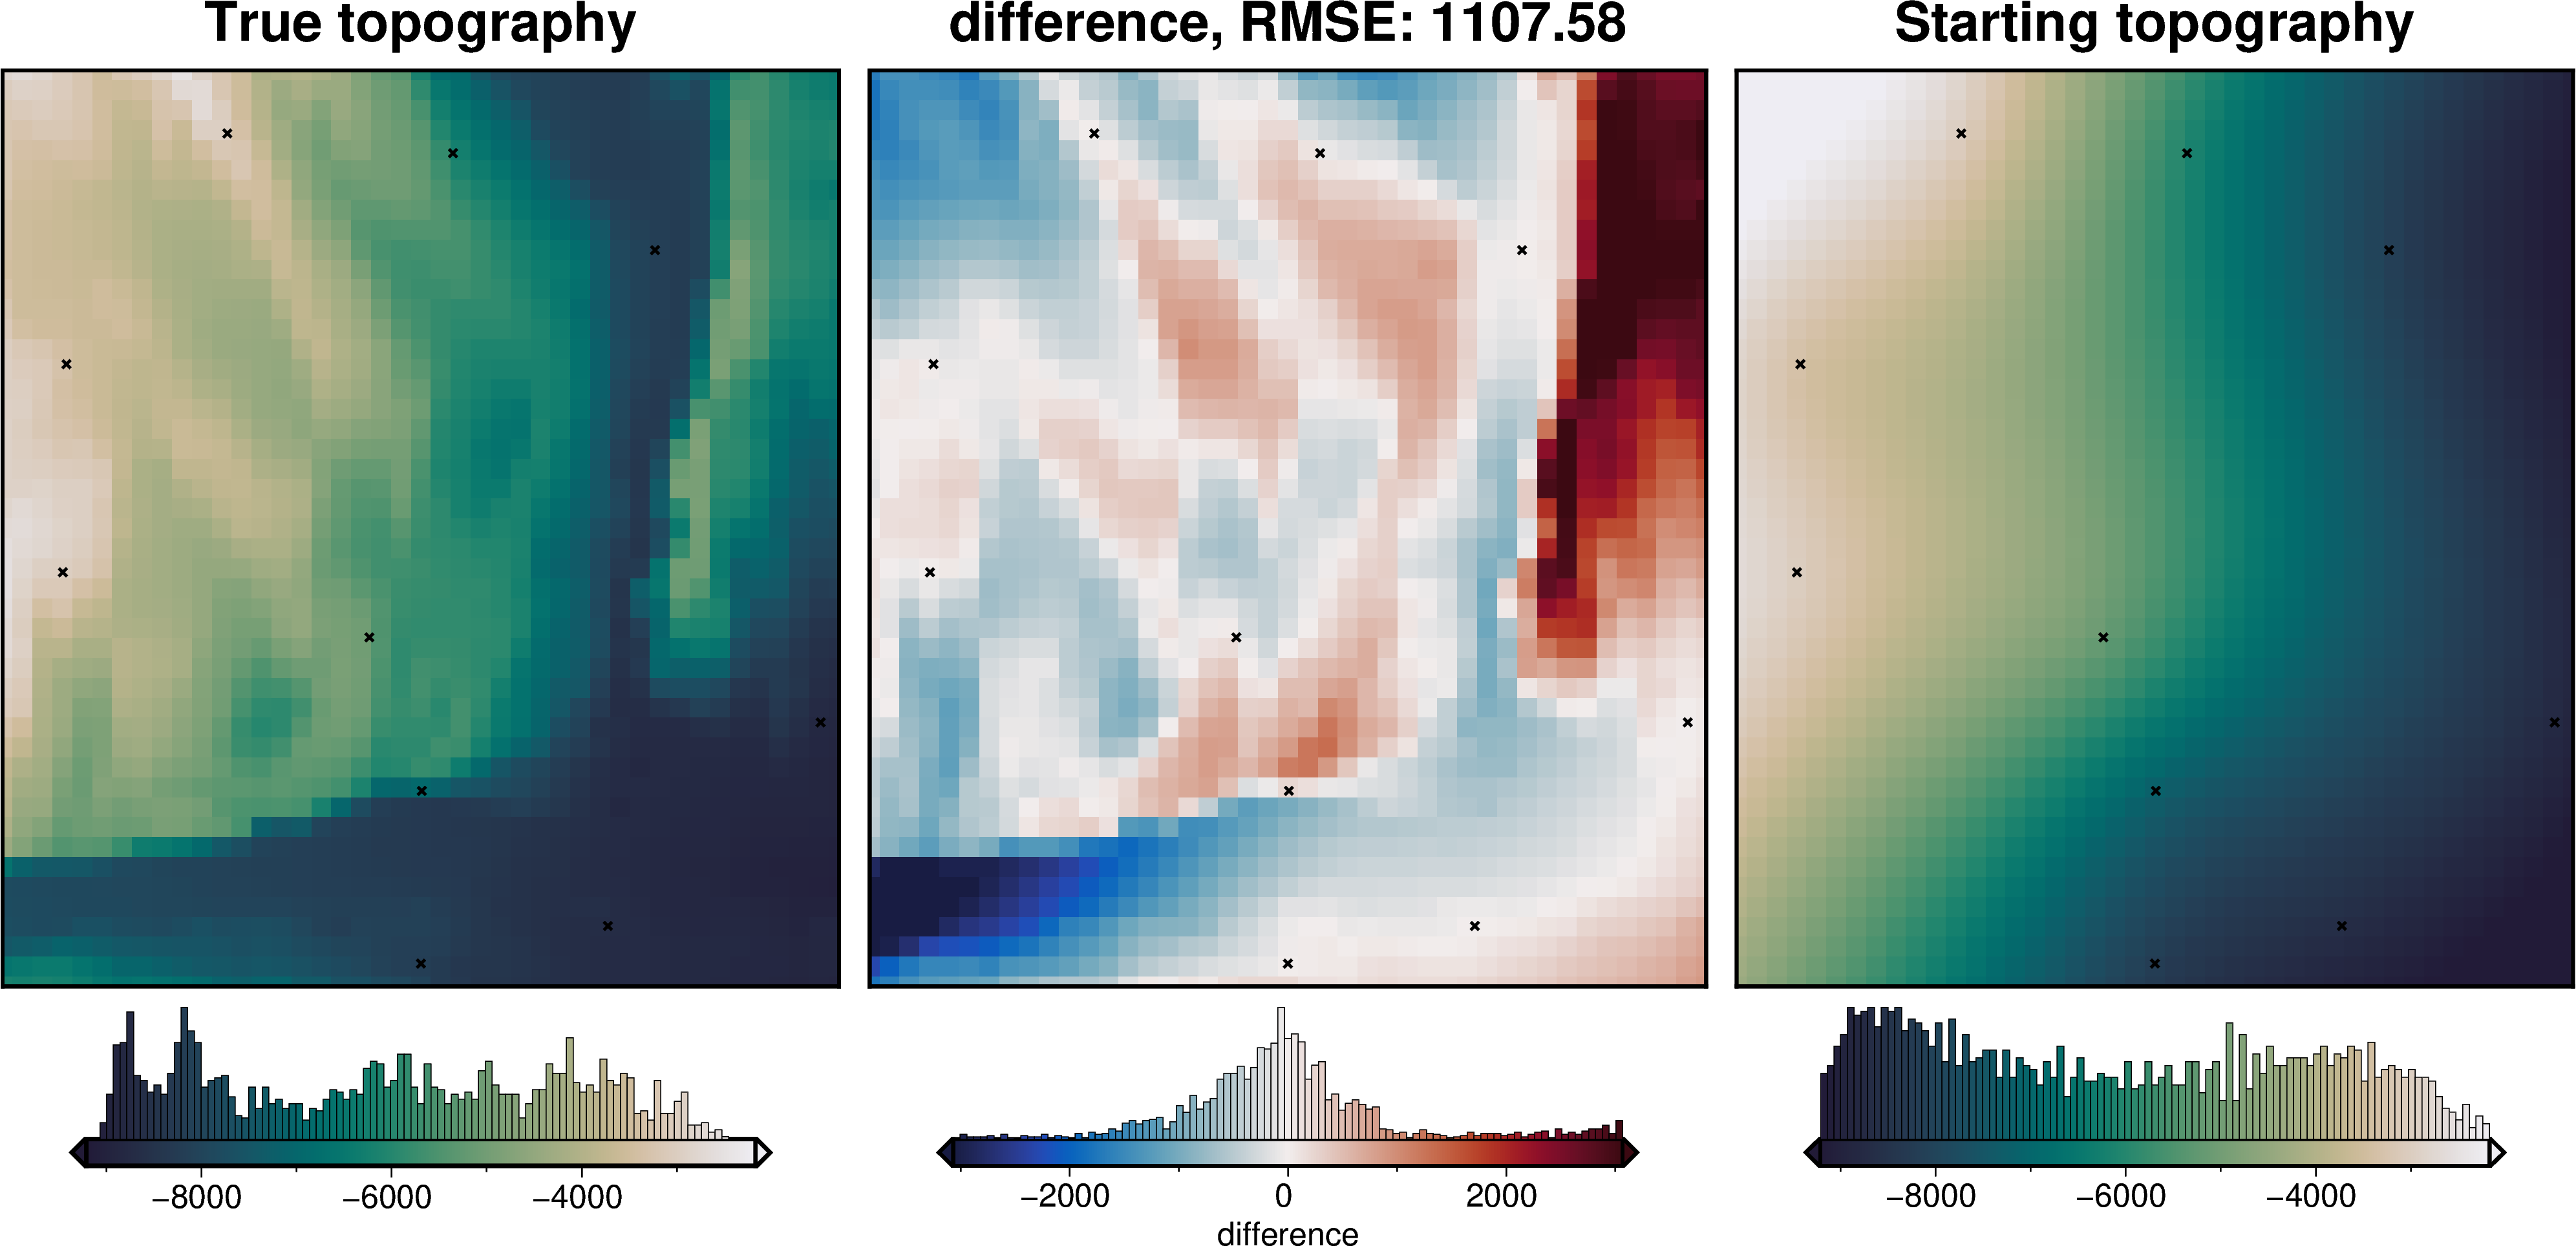

In [33]:
_ = polar_utils.grd_compare(
    data.basement,
    starting_topography,
    # plot_type="xarray",
    region=inversion_region,
    plot=True,
    grid1_name="True topography",
    grid2_name="Starting topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.15c",
)

zref: -6075.59 m


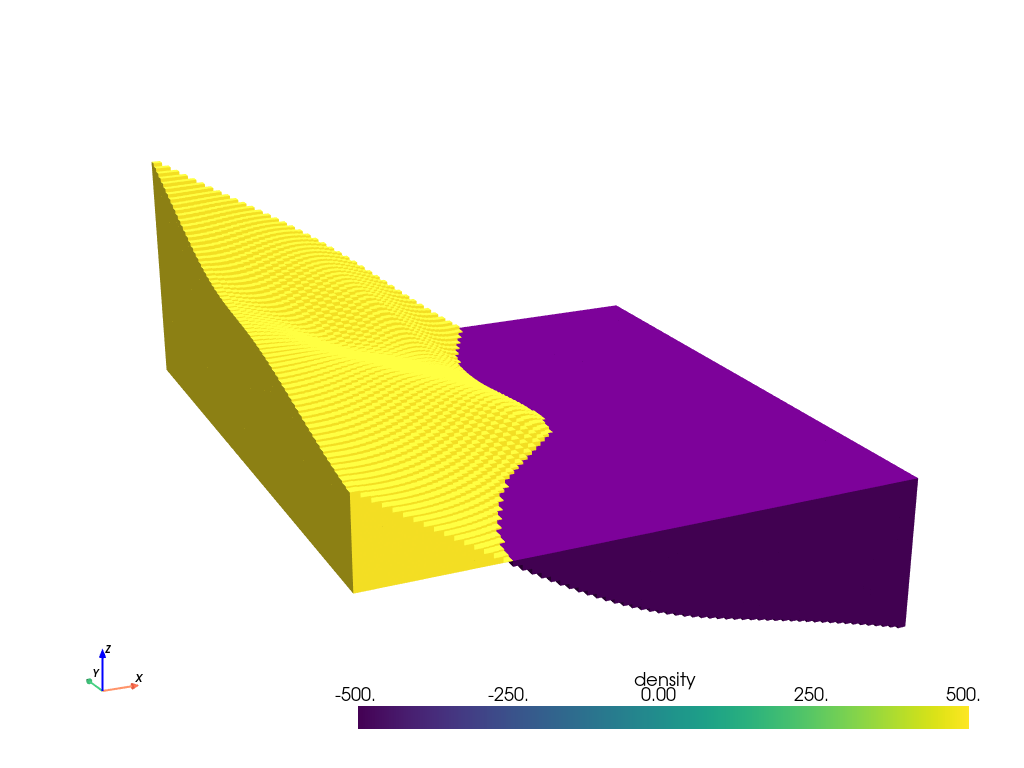

In [34]:
# pick a reference height for the basement
zref = starting_topography.values.mean()
print(f"zref: {zref:.2f} m")

# pick a density contrast for the basement
density_contrast = 2800 - 2300

density = xr.where(starting_topography >= zref, density_contrast, -density_contrast)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density,
)

plotting.show_prism_layers(
    starting_prisms,
    color_by="density",
    log_scale=False,
    zscale=20,
    backend="static",
)

# Gravity misfit

All inversions in Invert4Geom are based on a gravity misfit, not a gravity anomaly. This means before the inversion, we must create a starting prism model, forward model it's gravity effect, remove it from the gravity anomaly, and get a gravity misfit. 

However, if we know nothing about the starting model, it can simply be a flat layer of zero thickness, as we will use here. In this case, the forward gravity would just be zero so there is no need to perform the forward modelling. The misfit is therefore just equal to the topo-free disturbance.

### Forward gravity of starting prism layer

In [36]:
# calculate forward gravity of starting prism layer
grav_df["starting_grav"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

# calculate misfit as observed - starting
grav_df["misfit"] = grav_df.topo_free_disturbance - grav_df.starting_grav

# in many cases, we want to remove a regional signal from the misfit to isolate the
# residual signal. See user guide `estimating_regional_field` for explanations of the
# various options.

# use the constraints to find the best regional field
grav_df = regional.regional_constraints(
    constraint_points=constraint_points,
    grav_grid=grav_df.set_index(["northing", "easting"]).to_xarray().misfit,
    grav_df=grav_df,
    region=buffer_region,
    spacing=topo_spacing,
    tension_factor=0.25,
    regional_col_name="reg",
)

# remove the regional from the misfit to get the residual
grav_df["res"] = grav_df.misfit - grav_df.reg

grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

grav_df

  0%|          | 0/7905 [00:00<?, ?it/s]

,northing,easting,test,topo_free_disturbance,upward,moho_grav,starting_grav,misfit,reg,res
0,203900.0,64900.0,False,105.394936,10,0.723573,32.495864,72.899072,85.474541,-12.575469
1,203900.0,67900.0,True,106.236773,10,1.639907,30.648331,75.588442,86.903705,-11.315263
2,203900.0,70900.0,False,106.961624,10,2.556559,28.786221,78.175403,88.334801,-10.159398
3,203900.0,73900.0,True,107.668294,10,3.470678,26.923308,80.744986,89.767915,-9.022929
4,203900.0,76900.0,False,108.285965,10,4.380654,25.048129,83.237836,91.203178,-7.965343
...,...,...,...,...,...,...,...,...,...,...
7900,479900.0,304900.0,False,125.541908,10,25.686832,-51.042991,176.584899,157.281281,19.303619
7901,479900.0,307900.0,True,125.260601,10,26.058365,-52.094015,177.354616,158.650980,18.703636
7902,479900.0,310900.0,False,125.007927,10,26.403393,-53.116721,178.124648,160.017990,18.106658
7903,479900.0,313900.0,True,124.769899,10,26.721344,-54.110347,178.880247,161.382991,17.497256


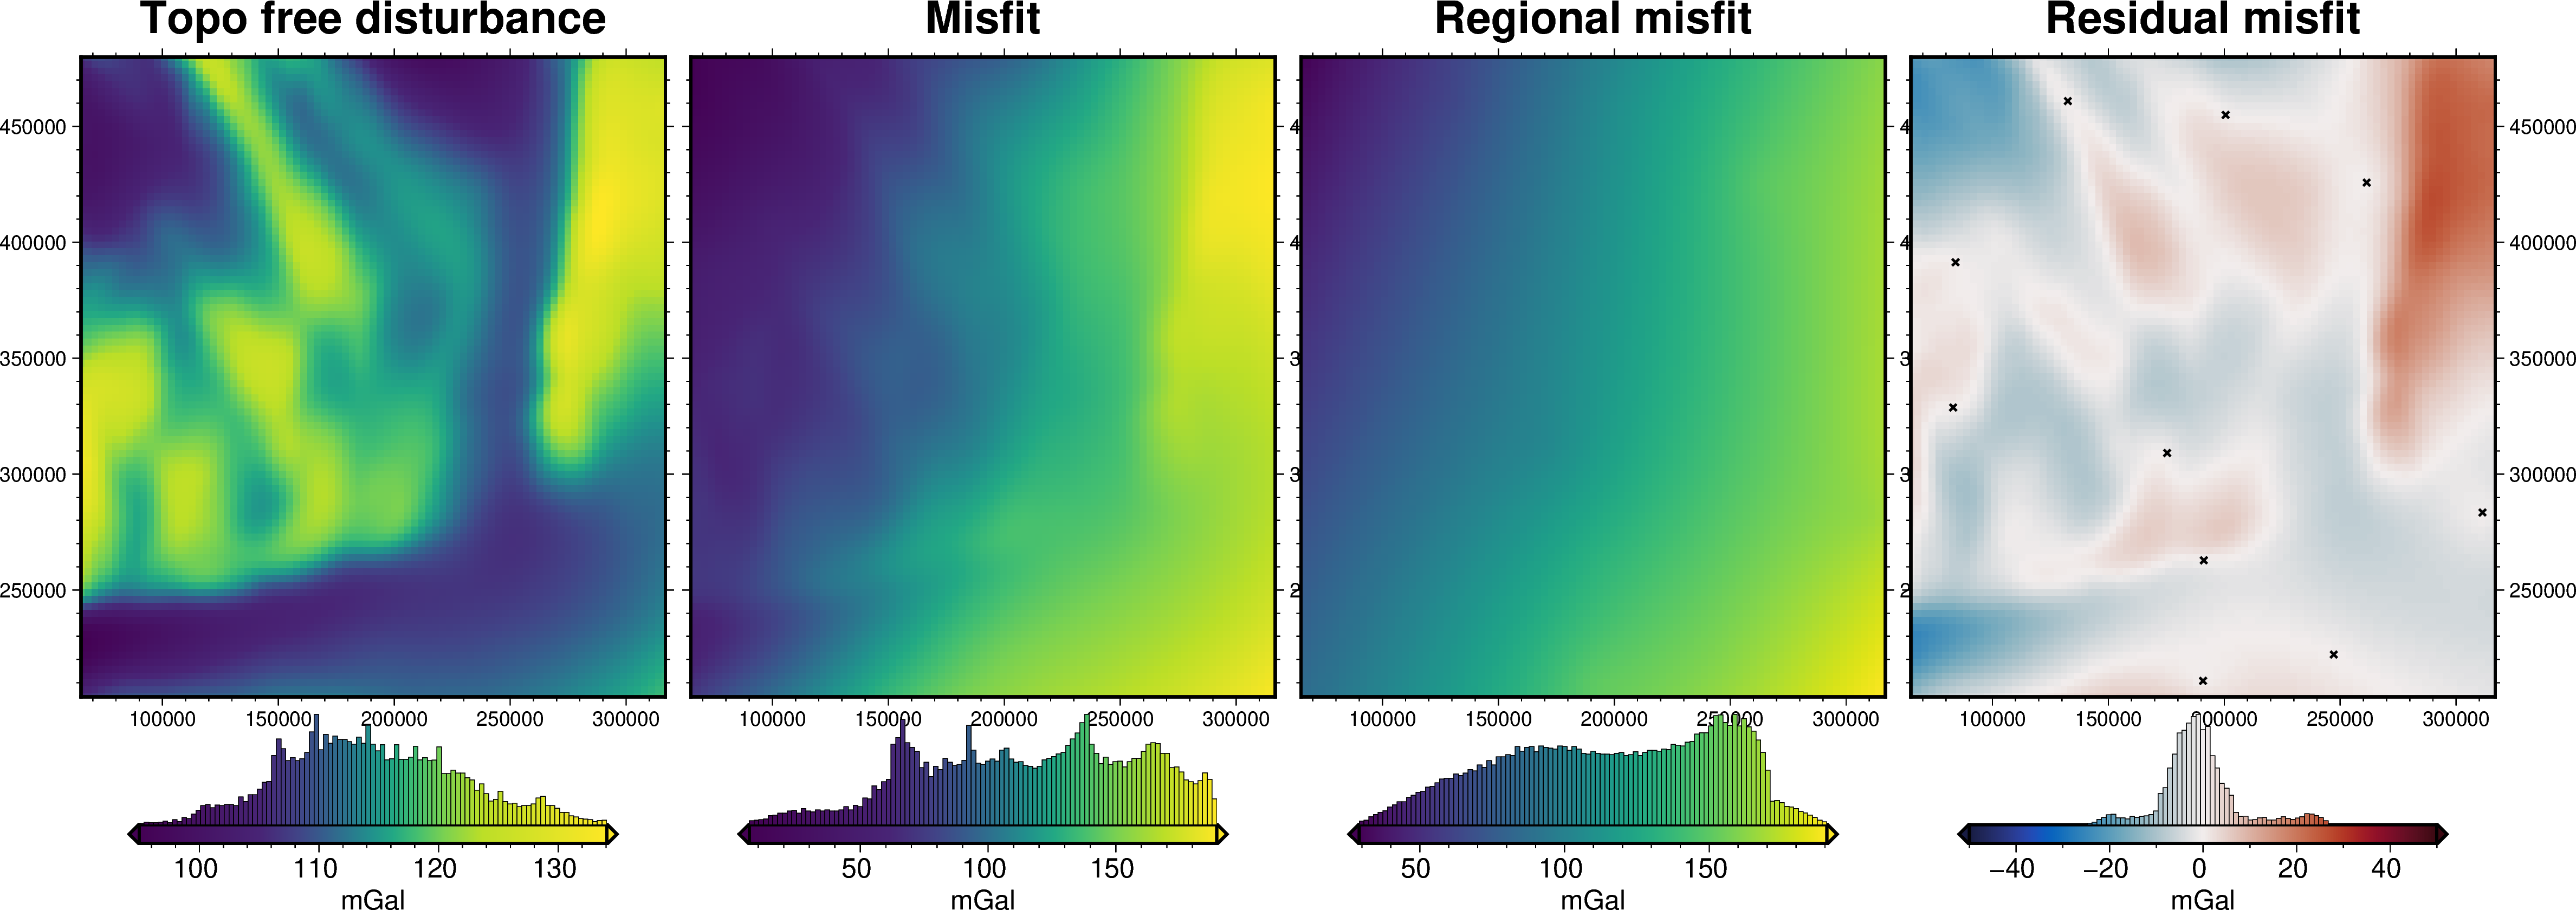

In [40]:
fig = maps.plot_grd(
    grav_grid.topo_free_disturbance,
    region=inversion_region,
    fig_height=10,
    title="Topo free disturbance",
    cmap="viridis",
    hist=True,
    grd2cpt=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.misfit,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Misfit",
    cmap="viridis",
    hist=True,
    grd2cpt=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.reg,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Regional misfit",
    cmap="viridis",
    hist=True,
    # grd2cpt=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.res,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Residual misfit",
    cmap="balance+h0",
    # cpt_lims=[-vd.maxabs(grav_grid.res), vd.maxabs(grav_grid.res)],
    cpt_lims=[-50, 50],
    hist=True,
    grd2cpt=False,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.15c",
)
fig.show()

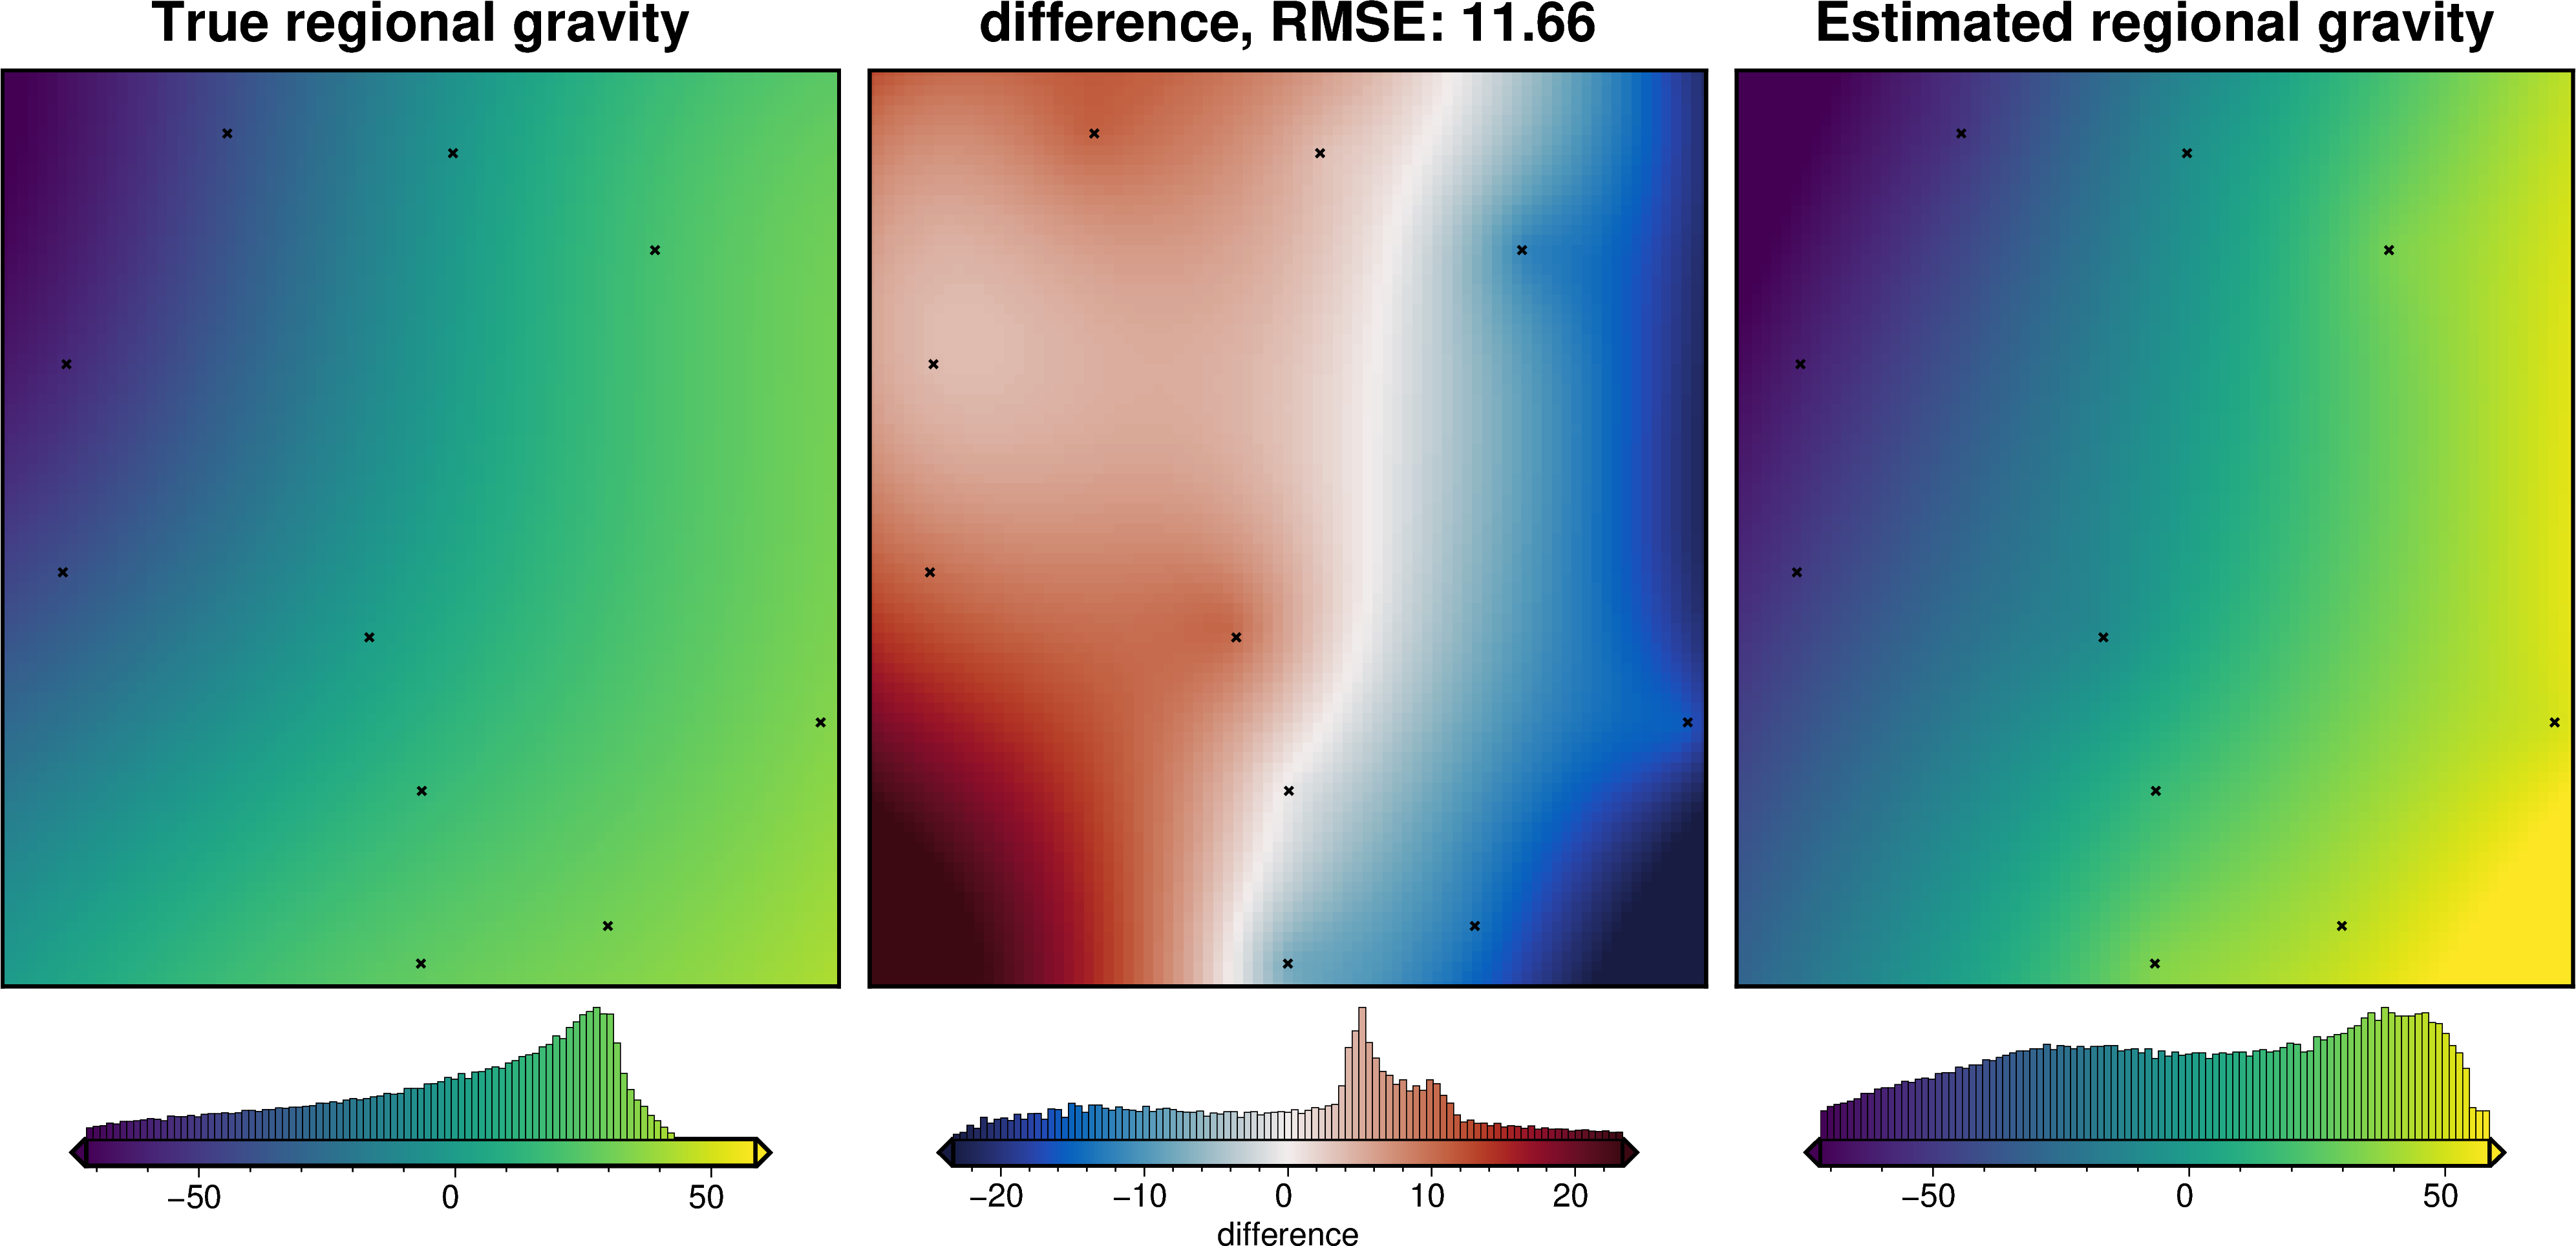

In [43]:
_ = polar_utils.grd_compare(
    grav_grid.moho_grav - np.mean(grav_grid.moho_grav),
    grav_grid.reg - np.mean(grav_grid.reg),
    region=inversion_region,
    # plot_type="xarray",
    plot=True,
    grid1_name="True regional gravity",
    grid2_name="Estimated regional gravity",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    # reverse_cpt=True,
    # cmap="rain",
    # diff_lims=(-20, 20),
    # frame=True,
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.15c",
)

# Damping parameter cross validation

In [44]:
# set Python's logging level
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

# set kwargs to pass to the inversion
kwargs = {
    "input_grav_column": "topo_free_disturbance",
    "prism_layer": starting_prisms,
    "deriv_type": "annulus",
    "zref": zref,
    "density_contrast": density_contrast,
    # set stopping criteria
    "max_iterations": 100,
    "l2_norm_tolerance": 0.2,
    "delta_l2_norm_tolerance": 1.005,
    # topographic bounds
    "upper_confining_layer": xr.ones_like(starting_topography),
    # region of interest
    "inversion_region": inversion_region,
}

# set which damping parameters to include
dampings = np.logspace(-4, -1, 12)

best_damping, _, _, scores = cross_validation.grav_optimal_parameter(
    training_data=grav_df[grav_df.test == False],  # noqa: E712
    testing_data=grav_df[grav_df.test == True],  # noqa: E712
    param_to_test=("solver_damping", dampings),
    progressbar=True,
    # plot_grids=True,
    plot_cv=False,
    verbose=True,
    **kwargs,
)

Parameter values:   0%|          | 0/12 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Parameter value: 0.0001 -> Score: 2.661065371244444
INFO:root:Parameter value: 0.0001873817422860383 -> Score: 1.9540809101471235
INFO:root:Parameter value: 0.0003511191734215131 -> Score: 0.5760427149102829
INFO:root:Parameter value: 0.0006579332246575682 -> Score: 0.27391068188192
INFO:root:Parameter value: 0.0012328467394420659 -> Score: 0.07842732447829615
INFO:root:Parameter value: 0.002310129700083158 -> Score: 0.06699892161241883
INFO:root:Parameter value: 0.004328761281083057 -> Score: 0.06869766874516839
INFO:root:Parameter value: 0.008111308307896872 -> Score: 0.06824523581491156
INFO:root:Parameter value: 0.01519911082952933 -> Score: 0.08688248931777617
INFO:root:Parameter value: 0.02848035868435799 -> Score: 0.15836825441804772
INFO:root:Parameter value: 0.05336699231206307 -> Score: 0.4248790371773816
INFO:root:Parameter value: 0.1 -> Score: 1.4275812206157275
INFO:root:Best score of 0.06699892161241883 with parameter value=0.002310129700083158


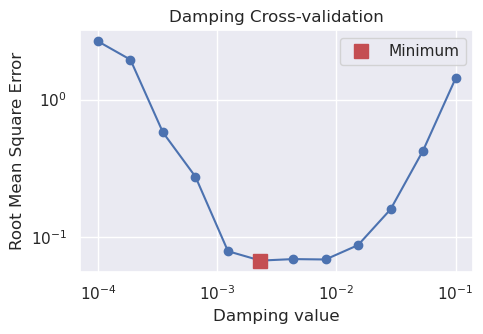

In [45]:
# Compare the scores and the damping values
plotting.plot_cv_scores(
    scores,
    dampings,
    param_name="Damping",
    logx=True,
    logy=True,
)

## Inversion with optimal damping parameter

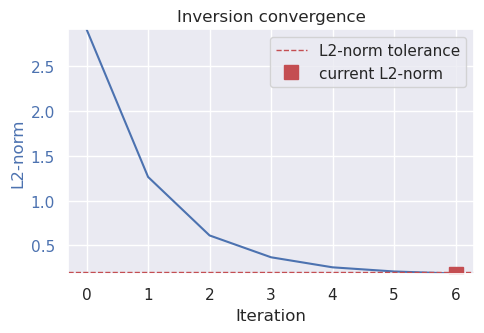

In [46]:
# set Python's logging level
# logger = logging.getLogger()
# logger.setLevel(logging.INFO)

# make new kwargs without solver damping
new_kwargs = {
    key: value
    for key, value in kwargs.items()
    if key
    not in [
        "solver_damping",
    ]
}

results = inversion.run_inversion(
    input_grav=grav_df[grav_df.test == False],  # noqa: E712, we can exlude the testing data now
    solver_damping=best_damping,
    plot_dynamic_convergence=True,
    **new_kwargs,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

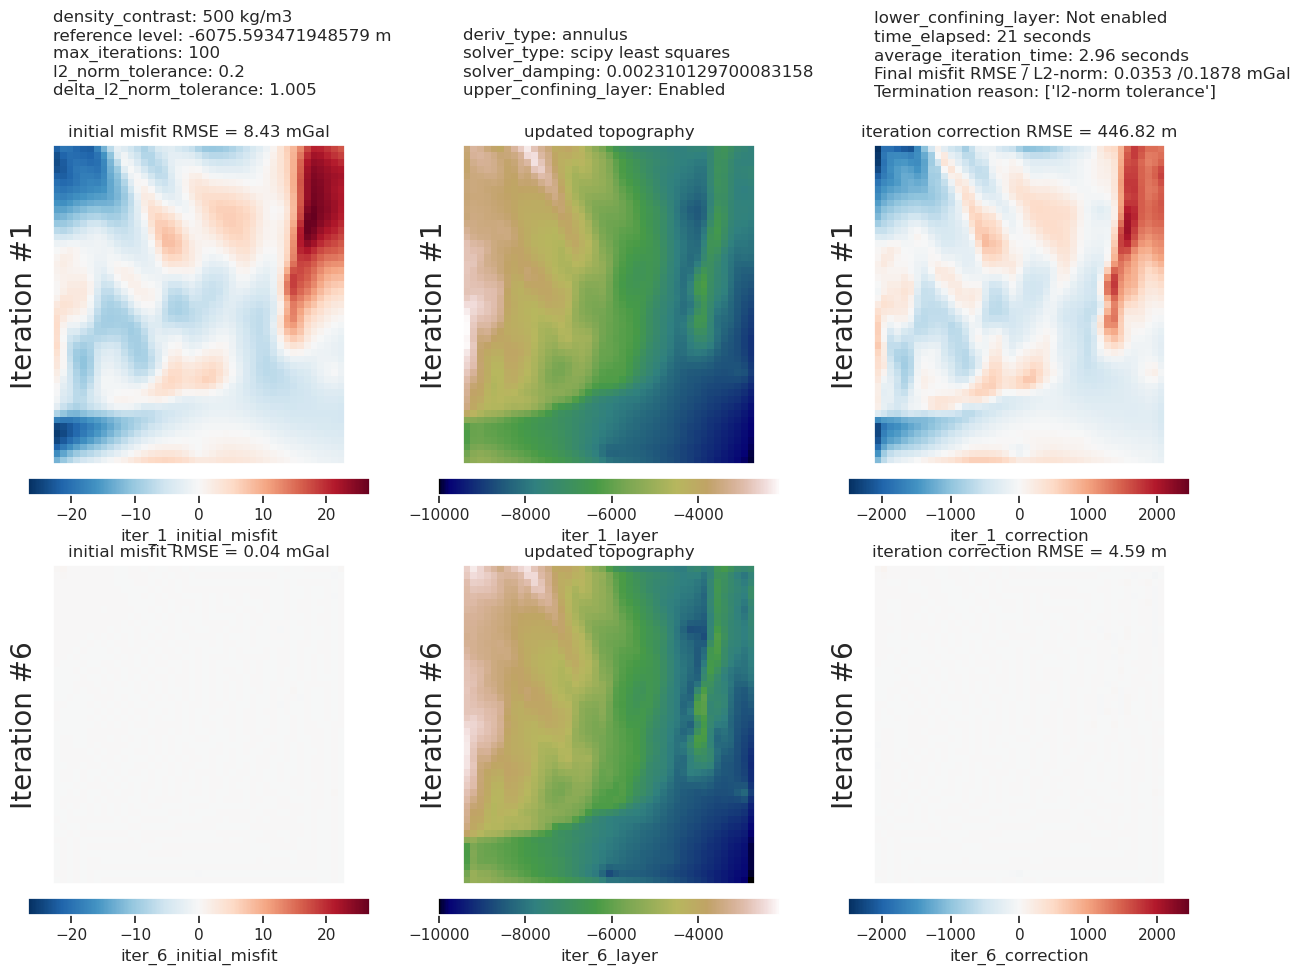

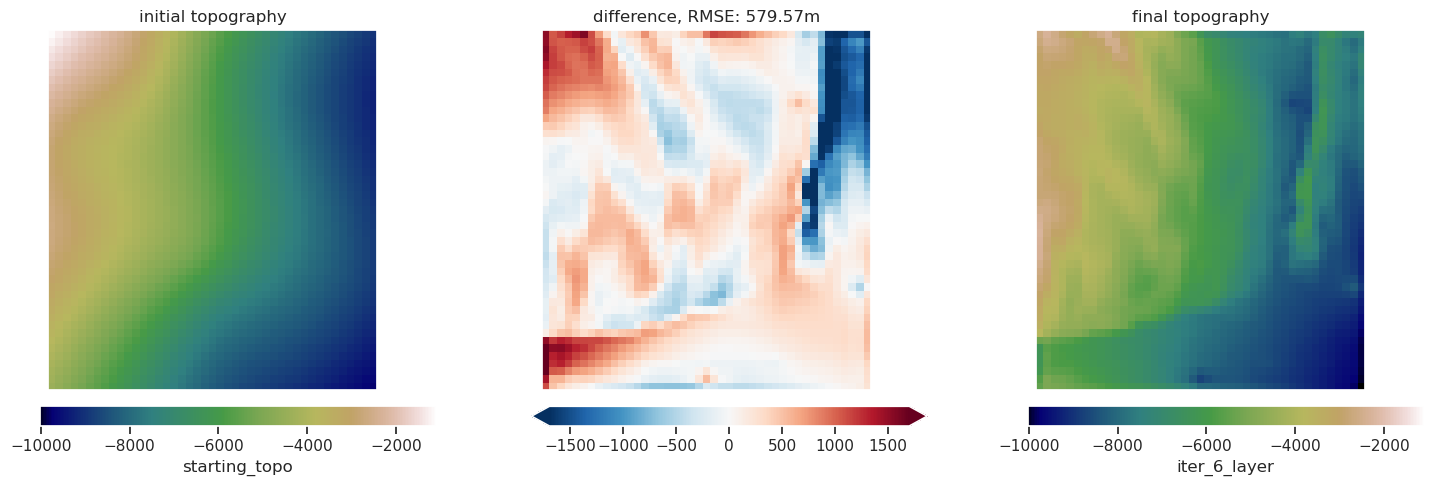

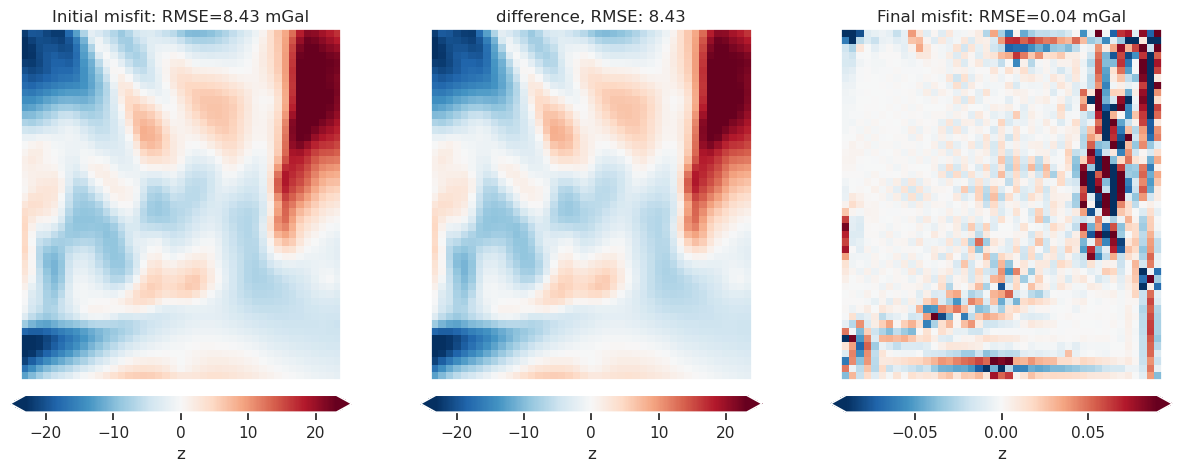

In [47]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    inversion_region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

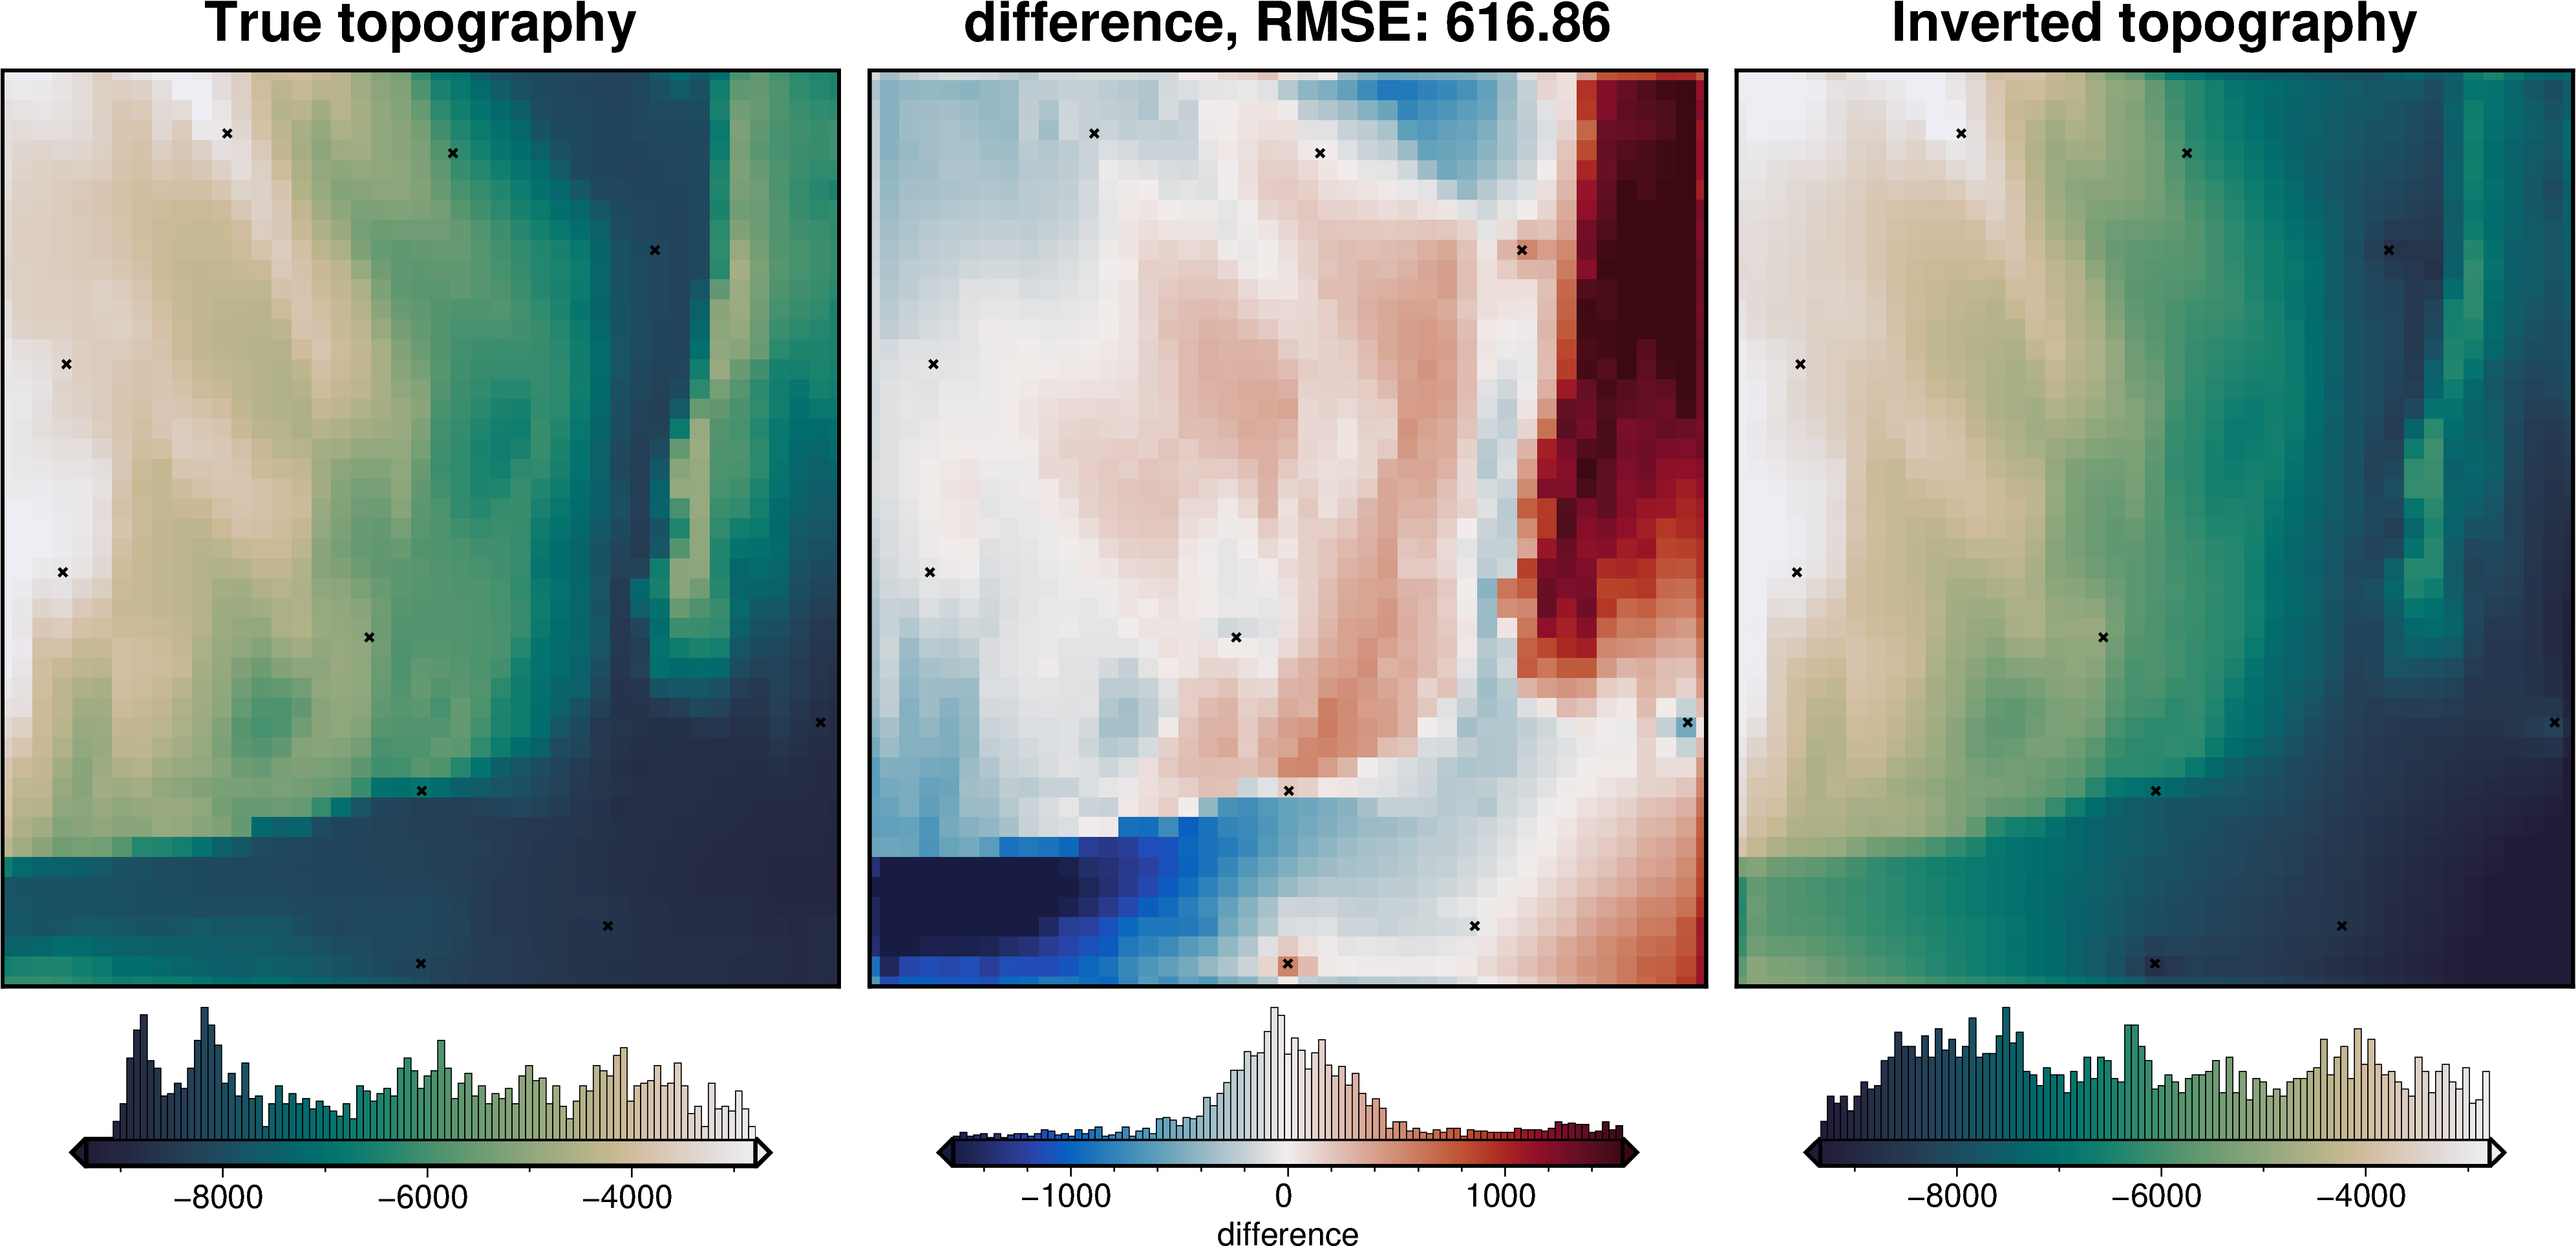

In [48]:
final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    data.basement,
    final_topography,
    region=inversion_region,
    # plot_type="xarray",
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.15c",
)

# Cross validation for density and reference level

We will use the optimal damping value found in the previous step.

In [49]:
# set Python's logging level
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

# update inversion kwargs
kwargs["solver_damping"] = best_damping

# set which zref values to include
zrefs = np.linspace(-12e3, 0, 6)

# set which density contrasts to include
density_contrasts = np.linspace(100, 1200, 6)

# create all possible combinations of zref and density contrast
parameter_pairs = list(itertools.product(zrefs, density_contrasts))

# we don't need the testing gravity data anymore
grav_df = grav_df[grav_df.test == False].copy()  # noqa: E712

# run inversions and collect scores
scores = []
for zref, density_contrast in tqdm(parameter_pairs, desc="Parameter pairs"):
    # re-calculate density grid with new density contrast
    density = xr.where(starting_topography >= zref, density_contrast, -density_contrast)

    # create layer of prisms
    starting_prisms = utils.grids_to_prisms(
        starting_topography,
        zref,
        density=density,
    )

    # calculate forward gravity of starting prism layer
    grav_df["starting_grav"] = starting_prisms.prism_layer.gravity(
        coordinates=(
            grav_df.easting,
            grav_df.northing,
            grav_df.upward,
        ),
        field="g_z",
        progressbar=False,
    )

    # calculate misfit as observed - starting
    grav_df["misfit"] = grav_df["topo_free_disturbance"] - grav_df["starting_grav"]

    # use the constraints to find the best regional field
    grav_df = regional.regional_constraints(
        constraint_points=constraint_points,
        grav_grid=grav_df.set_index(["northing", "easting"]).to_xarray().misfit,
        grav_df=grav_df,
        region=buffer_region,
        spacing=topo_spacing,
        tension_factor=0.25,
        regional_col_name="reg",
    )

    # remove the regional from the misfit to get the residual
    grav_df["res"] = grav_df.misfit - grav_df.reg

    # update zref value in kwargs
    kwargs["zref"] = zref

    # update density contrast value in kwargs
    kwargs["density_contrast"] = density_contrast

    # update starting model in kwargs
    kwargs["prism_layer"] = starting_prisms

    # run cross validation
    score = cross_validation.constraints_cv_score(
        grav=grav_df,
        constraints=constraint_points,
        **kwargs,
    )
    scores.append(score)

# print parameter and score pairs
for (zref, density_contrast), score in zip(parameter_pairs, scores):
    print(
        f"Reference level: {zref}, Density contrast: {density_contrast} -> Score: ",
        score,
    )

best_idx = np.argmin(scores)
best_score = scores[best_idx]
best_zref = parameter_pairs[best_idx][0]
best_density = parameter_pairs[best_idx][1]
print(
    f"Best score of {best_score} with reference level={best_zref} and density contrast",
    best_density,
)

Parameter pairs:   0%|          | 0/36 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Iteration:   0%|          | 0/100 [00:00<?, ?it/s]

Reference level: -12000.0, Density contrast: 100.0 -> Score:  492.470318351766
Reference level: -12000.0, Density contrast: 320.0 -> Score:  227.54592763962907
Reference level: -12000.0, Density contrast: 540.0 -> Score:  244.23300105104863
Reference level: -12000.0, Density contrast: 760.0 -> Score:  324.9092872223464
Reference level: -12000.0, Density contrast: 980.0 -> Score:  383.8654854032522
Reference level: -12000.0, Density contrast: 1200.0 -> Score:  393.4012819279883
Reference level: -9600.0, Density contrast: 100.0 -> Score:  492.5206988176663
Reference level: -9600.0, Density contrast: 320.0 -> Score:  222.63632873400545
Reference level: -9600.0, Density contrast: 540.0 -> Score:  243.3358183951466
Reference level: -9600.0, Density contrast: 760.0 -> Score:  324.8588975130191
Reference level: -9600.0, Density contrast: 980.0 -> Score:  387.71077574351125
Reference level: -9600.0, Density contrast: 1200.0 -> Score:  393.76067517670907
Reference level: -7200.0, Density contra

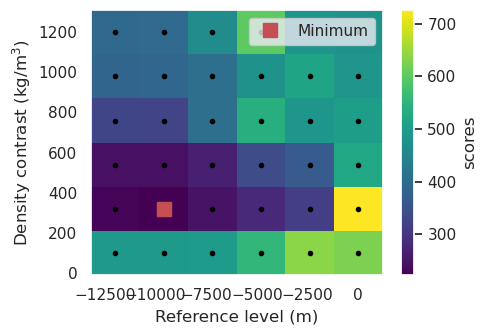

In [50]:
# Compare the scores and the damping values
plotting.plot_2_parameter_cv_scores(
    scores,
    parameter_pairs,
    param_names=("Reference level (m)", "Density contrast (kg/m$^3$)"),
    # logx=True,
    # logy=True,
    cmap="viridis",
)

## Run inversion with optimal damping, density and zref

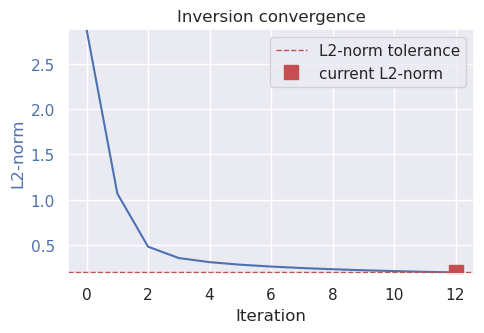

In [51]:
# set Python's logging level to get information about the inversion's progress
logger = logging.getLogger()
logger.setLevel(logging.WARNING)
# logger.setLevel(logging.INFO)

# re-calculate density grid with the best density contrast and zref
density = xr.where(starting_topography >= best_zref, best_density, -best_density)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    best_zref,
    density=density,
)

# calculate forward gravity of starting prism layer
grav_df["starting_grav"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=False,
)

# calculate misfit as observed - starting
grav_df["misfit"] = grav_df["topo_free_disturbance"] - grav_df["starting_grav"]

# use the constraints to find the best regional field
grav_df = regional.regional_constraints(
    constraint_points=constraint_points,
    grav_grid=grav_df.set_index(["northing", "easting"]).to_xarray().misfit,
    grav_df=grav_df,
    region=buffer_region,
    spacing=topo_spacing,
    tension_factor=0.25,
    regional_col_name="reg",
)

# remove the regional from the misfit to get the residual
grav_df["res"] = grav_df.misfit - grav_df.reg

# update kwargs to pass to the inversion
kwargs["prism_layer"] = starting_prisms
kwargs["zref"] = best_zref
kwargs["density_contrast"] = best_density
kwargs["solver_damping"] = best_damping

# run the inversion
results = inversion.run_inversion(
    input_grav=grav_df,
    # display the convergence of the inversion
    plot_dynamic_convergence=True,
    **kwargs,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

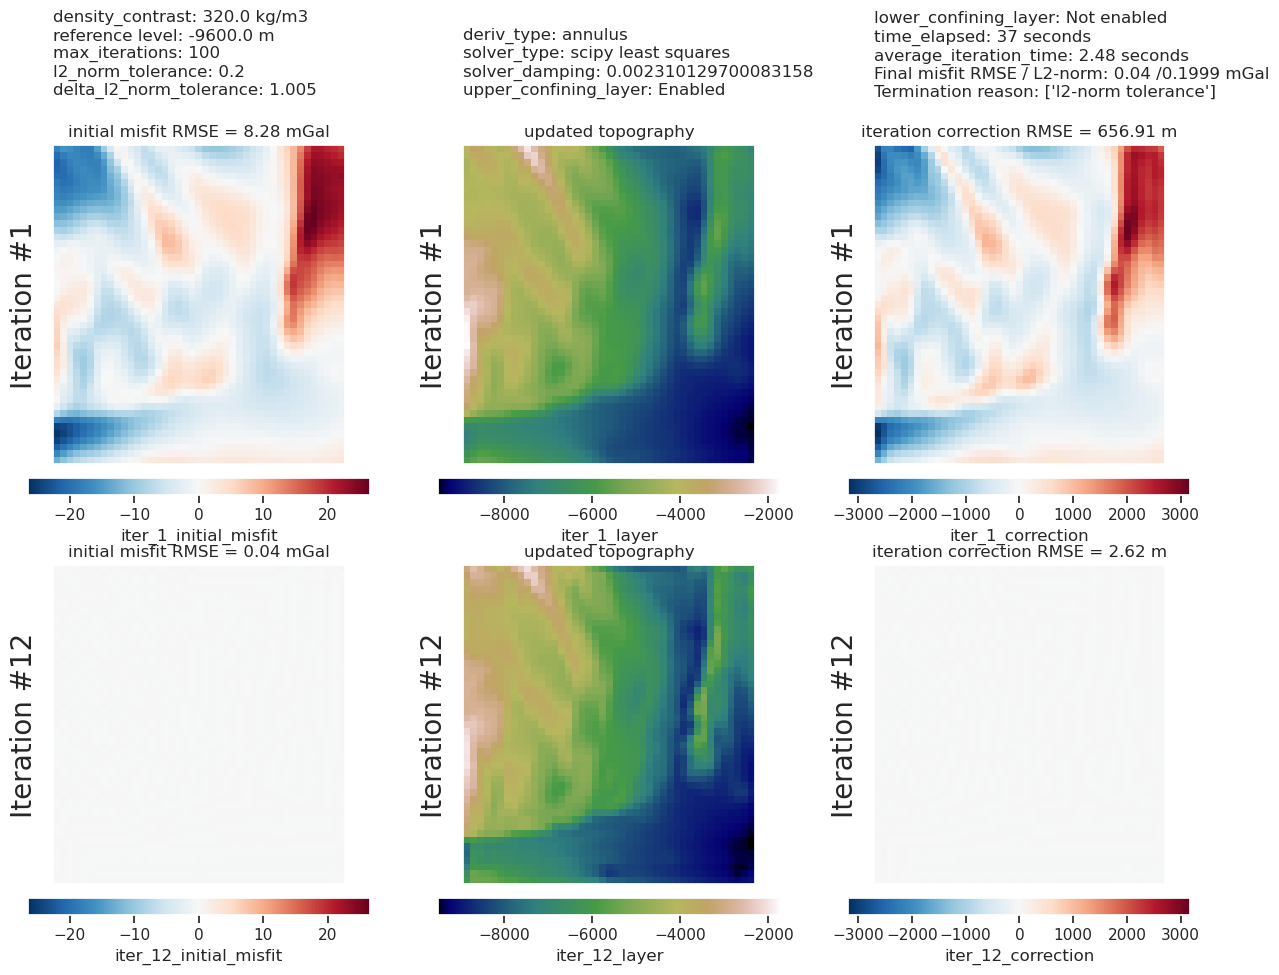

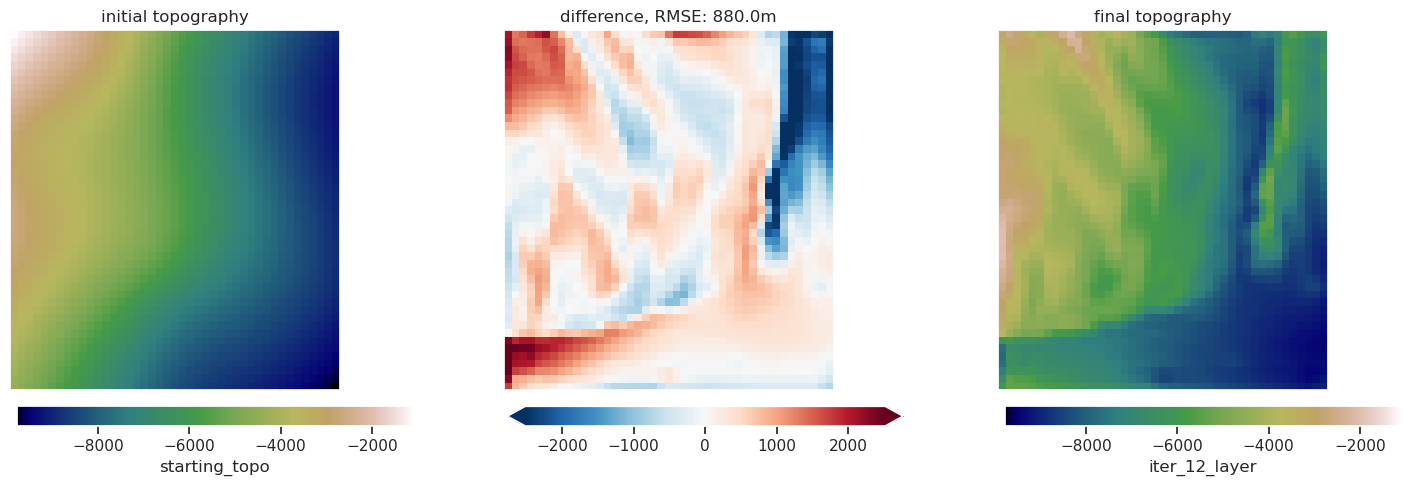

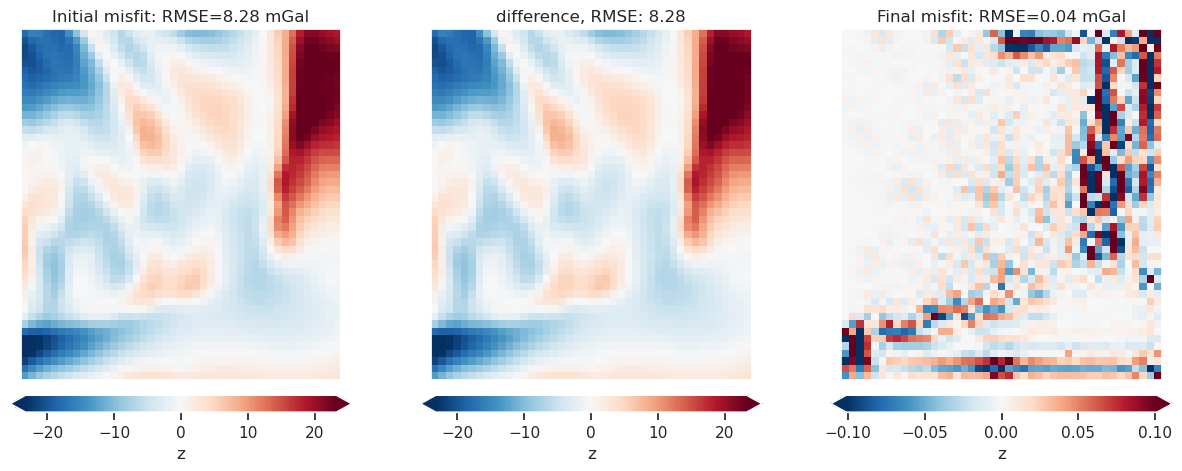

In [52]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    inversion_region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

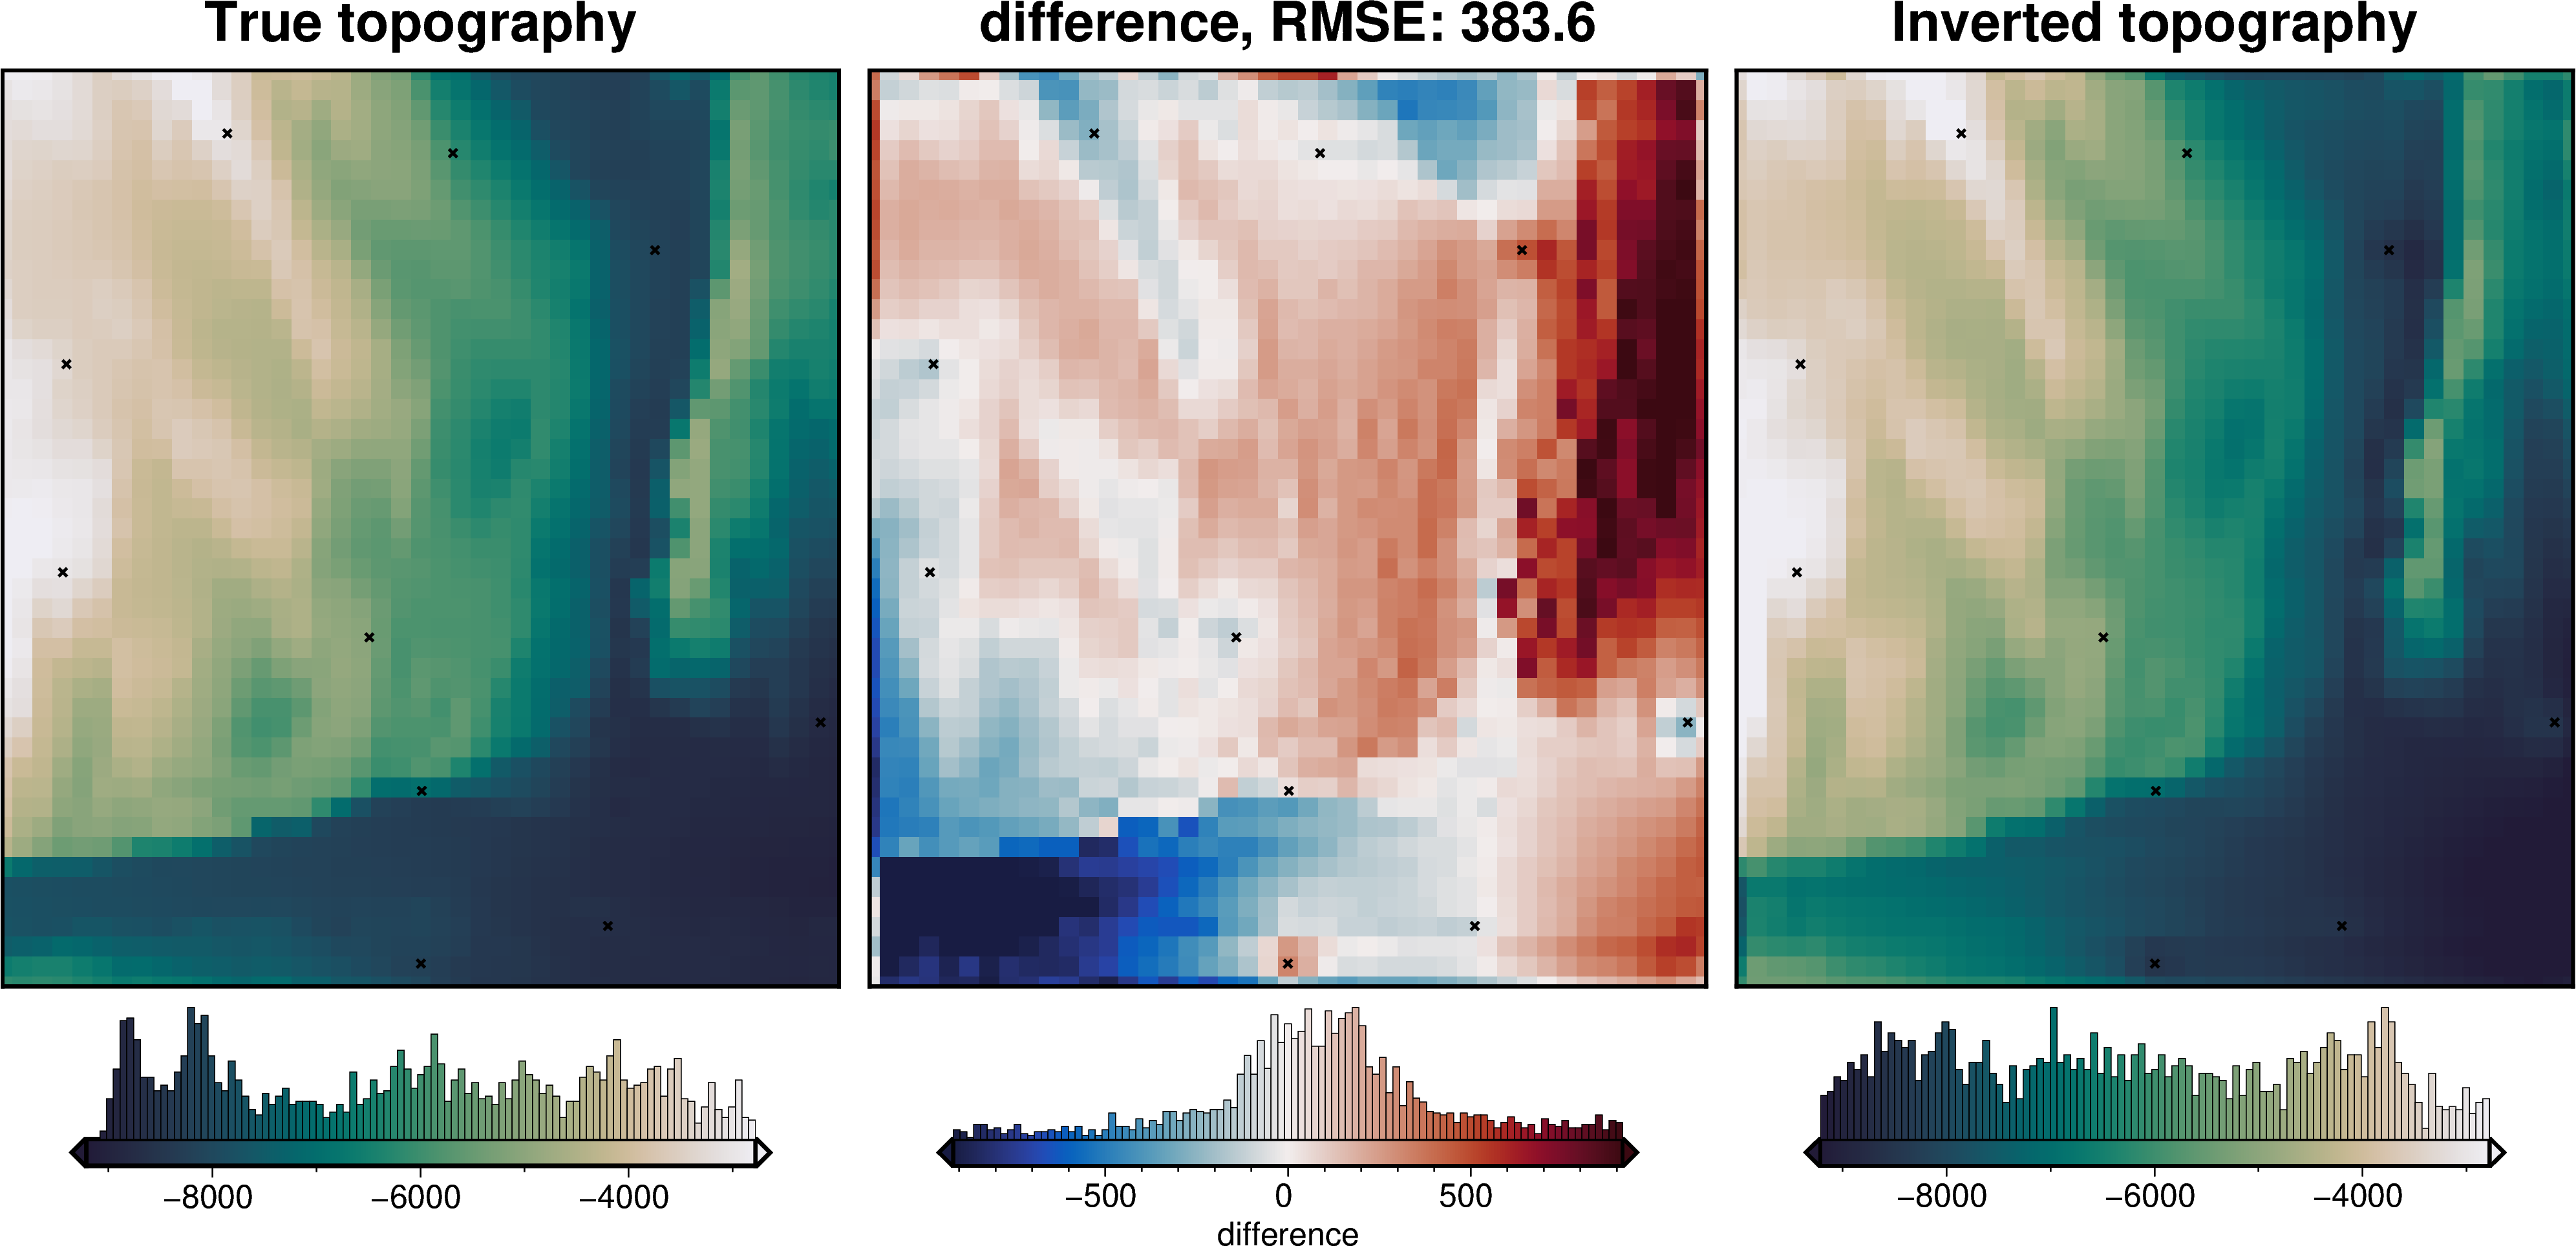

In [53]:
final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    data.basement,
    final_topography,
    # plot_type="xarray",
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    region=inversion_region,
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.15c",
)

In [54]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 222.64 m


## Adhering to constraints: weighting grid
To force the invesion to adhere to the starting model we need to supply a weighting grid. At each iteration, the `correction grid` is multiplied by this weighting grid to alter the iteration's correction. Therefore, this weighting grid should be ~0 at the constraints, so that they aren't altered from the starting model. These values should increase to ~1 at a distance to allow the inversion to be un-affected at locations far from constraints. 

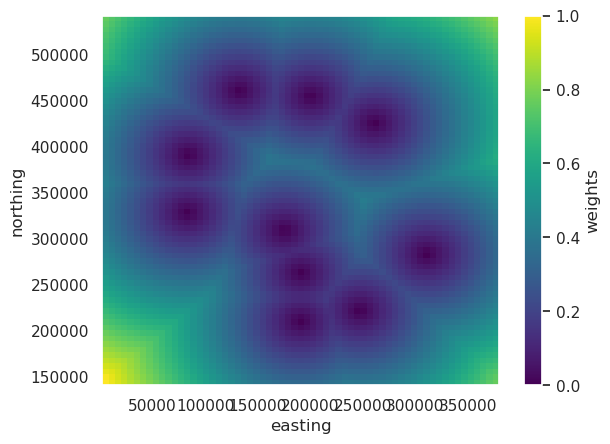

In [55]:
# calculate the distance between each grid cell and the nearest constraint, then
# normalize those values between 0 and 1
min_dist = utils.normalized_mindist(
    constraint_points,
    starting_prisms,
    low=0,
    high=1,
)
starting_prisms["weights"] = min_dist
starting_prisms.weights.plot()

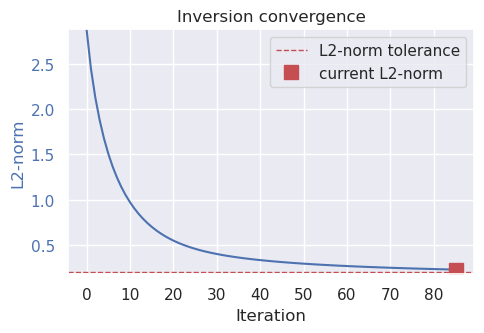

In [56]:
# update inversion kwargs
kwargs["weights_after_solving"] = True
kwargs["prism_layer"] = starting_prisms

# run the inversion
results = inversion.run_inversion(
    input_grav=grav_df,
    # display the convergence of the inversion
    plot_dynamic_convergence=True,
    **kwargs,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

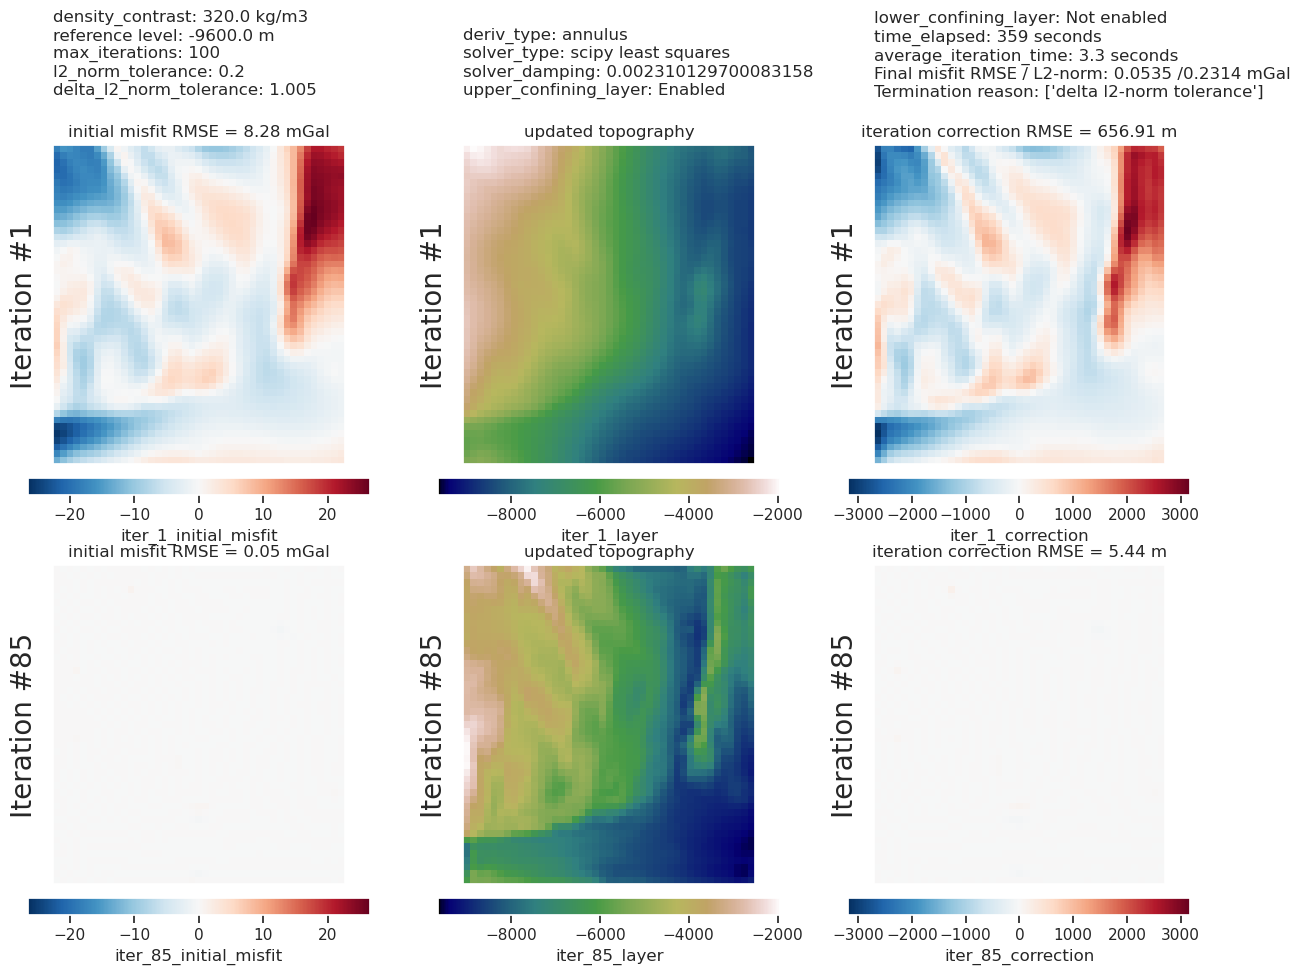

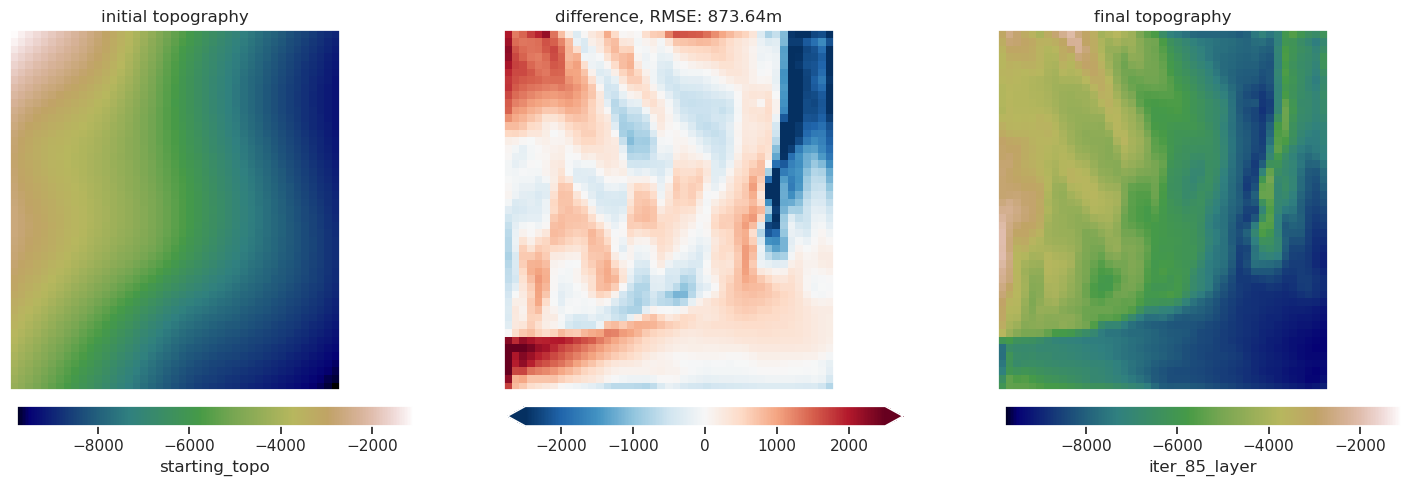

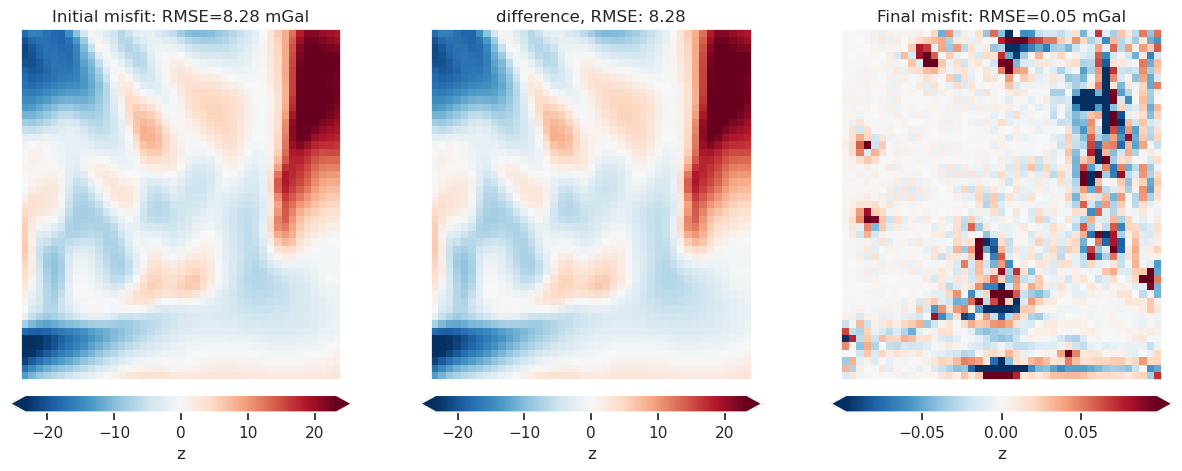

In [57]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    grav_region=inversion_region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

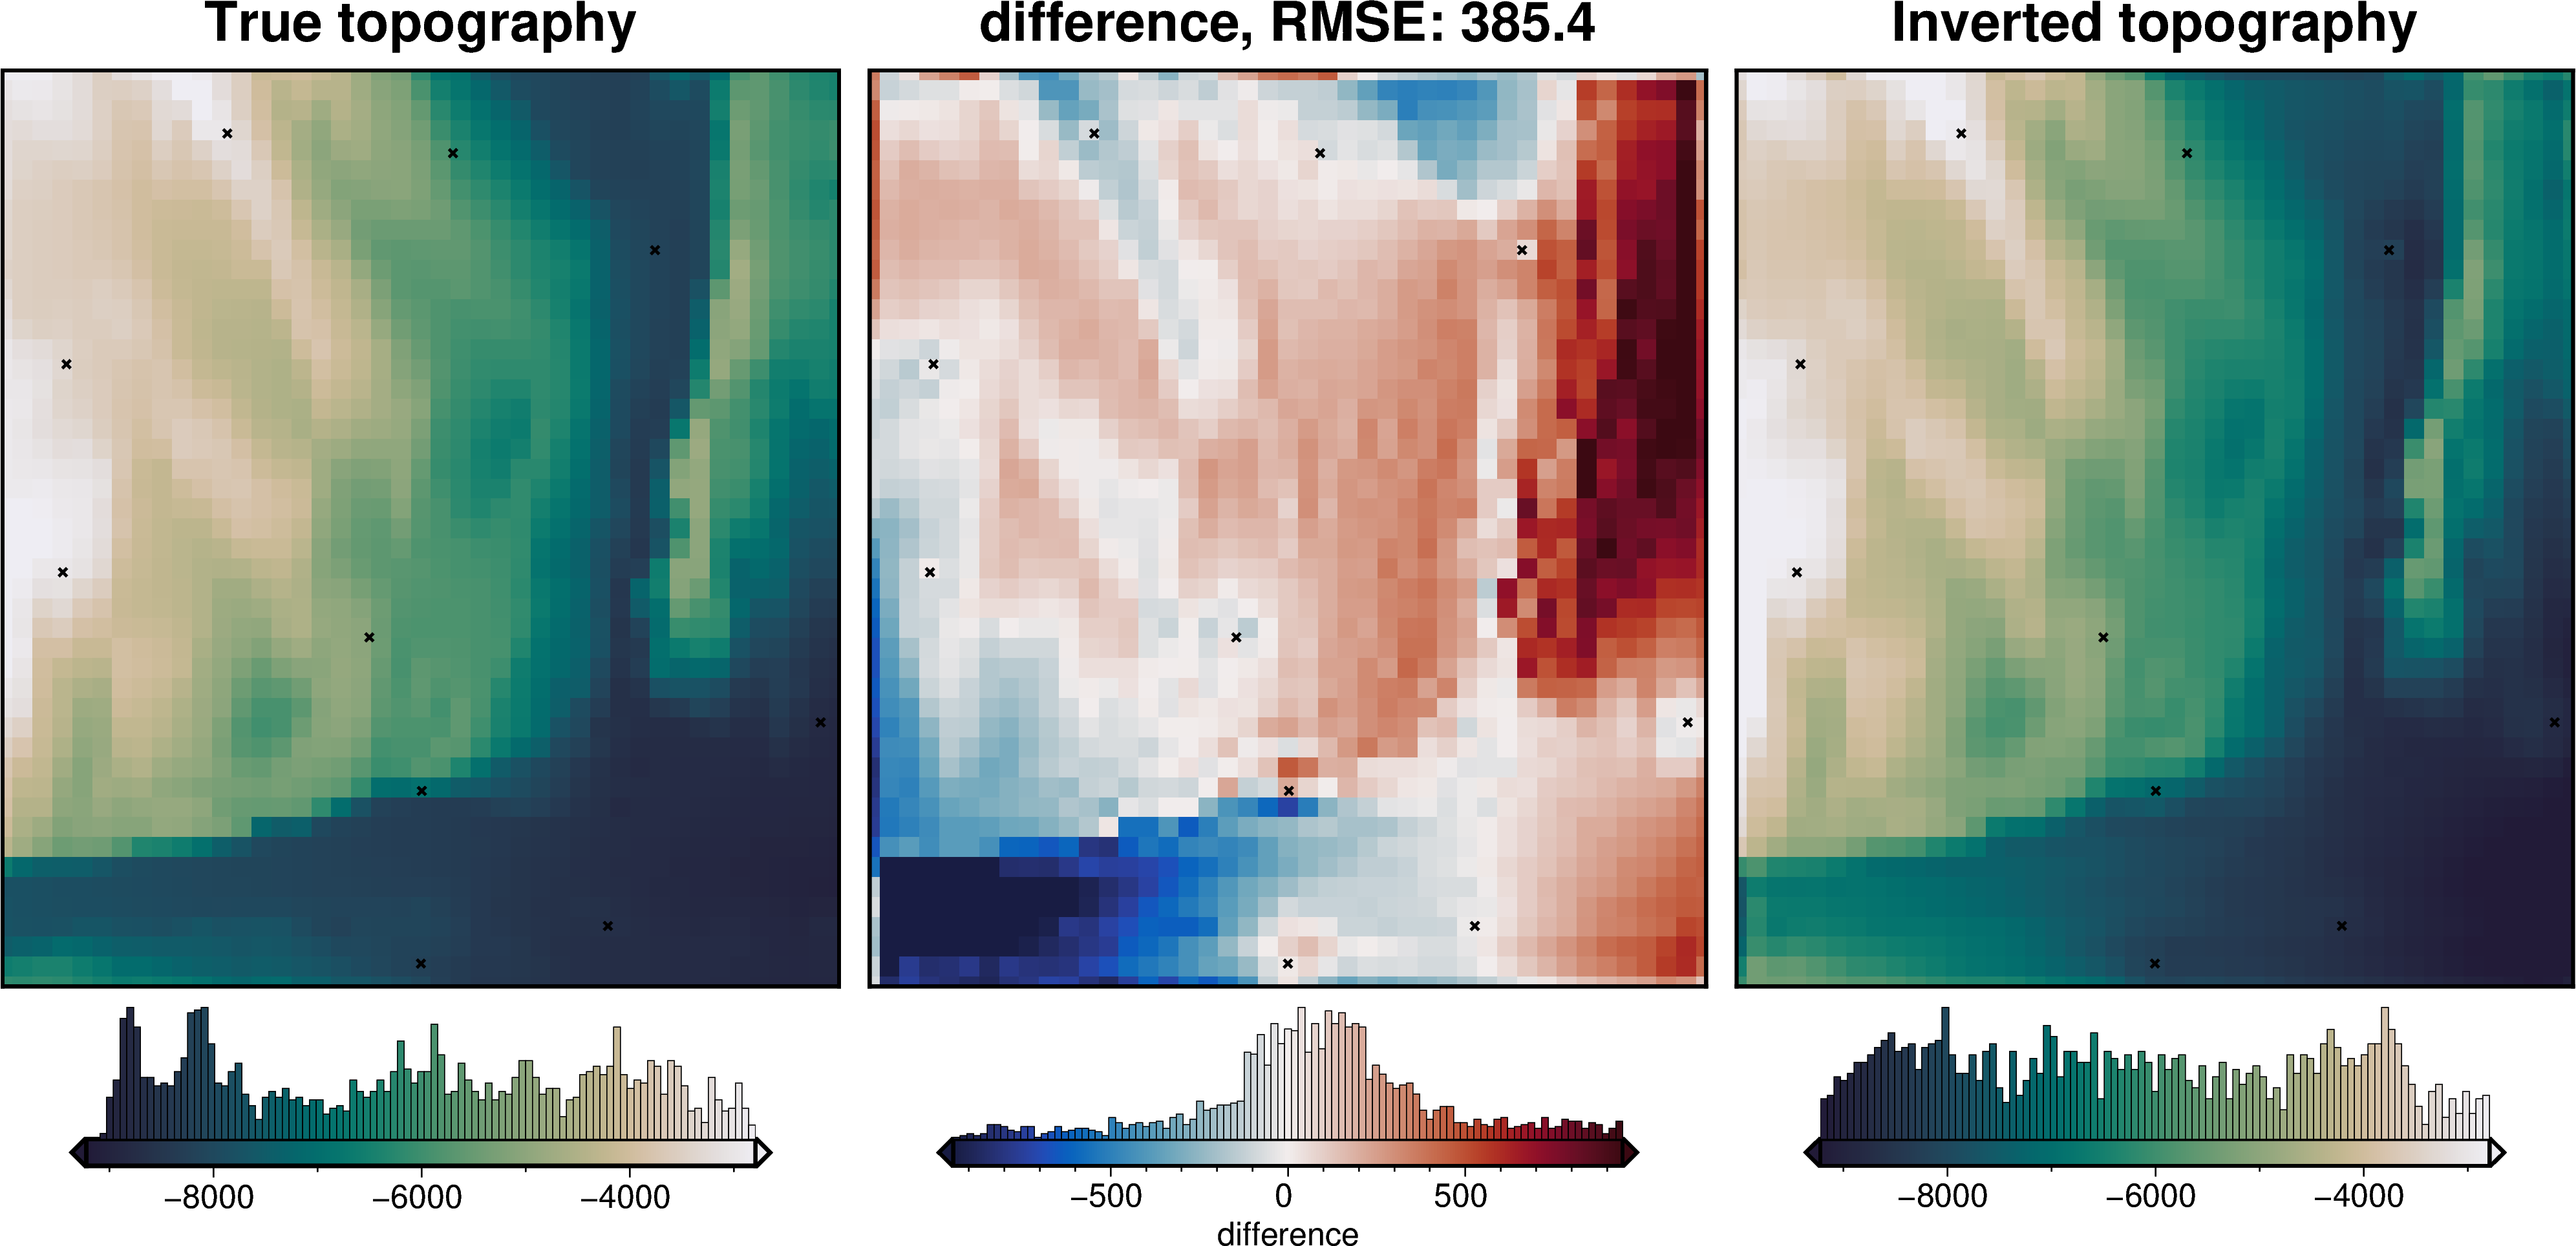

In [58]:
final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    data.basement,
    final_topography,
    # plot_type="xarray",
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    region=inversion_region,
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.15c",
)

In [59]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 48.97 m
